Llegim dades, i convertim en forma:
    'ecg': I,II,III,AVR,...
    'metadata': Age, sex, HTA, ...
    'label': OTorigin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pickle

# Full path to the file
file_path = "/content/drive/Shared drives/CompBiomedSemis/DL-RAW DATA/all_points_may_2024.pkl"

# Load the data
with open(file_path, "rb") as f:
    all_points_data = pickle.load(f)

# Confirm successful loading
print("Loaded data type:", type(all_points_data))
print("Sample keys:", list(all_points_data.keys())[:5])


Loaded data type: <class 'dict'>
Sample keys: ['P186', 'P245', 'P292', 'P205', 'P066']


Inspect the Dataset

In [ ]:
from collections import Counter

# Simplification map for Left/Right
simplified_map = {
    'Right ventricle': 'Right',
    'RVOT': 'Right',
    'Coronary sinus': 'Right',
    'Tricuspid annulus': 'Right',
    'LVOT': 'Left',
    'Left ventricle': 'Left',
    'Mitral annulus': 'Left'
}

# Loop and classify
labels = []
simplified_labels = []
for patient in all_points_data.values():
    label_list = patient.get('SOO_chamber', [])
    label = label_list[0] if label_list else 'Unknown'
    labels.append(label)
    simplified_labels.append(simplified_map.get(label, 'Unknown'))

# Show counts
print("Total patients:", len(all_points_data))
print("SOO_chamber label counts:")
print(Counter(labels))
print("\n Simplified Left/Right label counts:")
print(Counter(simplified_labels))


Total patients: 190
SOO_chamber label counts:
Counter({'RVOT': 76, 'Right ventricle': 57, 'LVOT': 36, 'Coronary sinus': 8, 'Tricuspid annulus': 6, 'Mitral annulus': 4, 'Left ventricle': 3})

 Simplified Left/Right label counts:
Counter({'Right': 147, 'Left': 43})


Reestructure the data

In [ ]:
structured_data = []
max_ecgs_right = 10
max_ecgs_left = 41  # take more ECGs from Left patients

for patient_id, info in all_points_data.items():
    label_list = info.get('SOO_chamber', [])
    if not label_list:
        continue

    label = label_list[0]
    simplified_label = simplified_map.get(label, 'Unknown')
    if simplified_label == 'Unknown':
        continue

    # Metadata
    patient_metadata = {}
    for key in metadata_keys:
        val = info.get(key, [None])[0]
        if pd.isna(val):
            patient_metadata[key] = -1
        elif key in binary_map:
            patient_metadata[key] = binary_map[key].get(val, -1)
        else:
            patient_metadata[key] = val

    # ECGs
    try:
        structures = list(info['Structures'].values())[0]
        ecg_ids = list(structures.keys())
        np.random.shuffle(ecg_ids)

        limit = max_ecgs_left if simplified_label == 'Left' else max_ecgs_right

        for ecg_id in ecg_ids[:limit]:
            ecg = structures[ecg_id]
            if len(ecg) < 12 or not all(lead in ecg for lead in ecg_leads):
                continue

            ecg_sample = {lead: ecg[lead] for lead in ecg_leads}
            entry = {
                'ecg': ecg_sample,
                'metadata': patient_metadata,
                'label': label,
                'simplified': simplified_label
            }
            structured_data.append(entry)
    except:
        continue

print(f"Total structured samples: {len(structured_data)}")
label_counts = Counter([d['simplified'] for d in structured_data])
print("Label distribution:", label_counts)


Total structured samples: 2650
Label distribution: Counter({'Right': 1330, 'Left': 1320})


In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter

# ECG lead names
ecg_leads = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Metadata keys to extract per patient
metadata_keys = [
    'Sex', 'HTA', 'Age', 'PVC_transition', 'SOO_chamber', 'Height', 'Weight', 'BMI',
    'DM', 'DLP', 'Smoker', 'COPD', 'Sleep_apnea', 'CLINICAL_SCORE', 'SOO', 'OTorigin'
]

# Binary encoding map for categorical fields
binary_map = {
    'Sex': {'M': 1, 'F': 0},
    'HTA': {'Yes': 1, 'No': 0},
    'DM': {'Yes': 1, 'No': 0},
    'DLP': {'Yes': 1, 'No': 0},
    'Smoker': {'Yes': 1, 'No': 0},
    'COPD': {'Yes': 1, 'No': 0},
    'Sleep_apnea': {'Yes': 1, 'No': 0}
}

# Optional: Build label encoders if you'll use SOO or SOO_chamber numerically
label_encoders = defaultdict(dict)

# Collect values from structured_data if already built
all_soo_chambers = [entry['metadata']['SOO_chamber'] for entry in structured_data]
all_soo = [entry['metadata']['SOO'] for entry in structured_data]

for key, values in [('SOO_chamber', all_soo_chambers), ('SOO', all_soo)]:
    unique_values = sorted(set(str(v) for v in values))
    label_encoders[key] = {val: idx for idx, val in enumerate(unique_values)}

# Print a preview of encoders (optional)
print("Label encoder for SOO_chamber:", label_encoders['SOO_chamber'])
print("Label encoder for SOO:", label_encoders['SOO'])


Label encoder for SOO_chamber: {}
Label encoder for SOO: {}


**Data balancing**

In [ ]:
y = [patient['simplified'] for patient in structured_data]  # Use simplified Left/Right

X = np.array([
    np.array([patient['ecg'][lead] for lead in ecg_leads])  # shape (12, signal_length)
    for patient in structured_data
])
patient_metadata = [patient['metadata'] for patient in structured_data]

target_labels = {'Right', 'Left'}
y = pd.Series(y)

valid_indices = y[y.isin(target_labels)].index
X_filtered = X[valid_indices]
y_filtered = y[valid_indices]
print(f"Filtered data shape: {X_filtered.shape}, Labels shape: {y_filtered.shape}")

df = pd.DataFrame({'index': valid_indices, 'label': y_filtered})

# Balance the data by augmenting the minority label
class_counts = y_filtered.value_counts()
min_class = class_counts.idxmin()
max_class = class_counts.idxmax()
n_to_add = class_counts[max_class] - class_counts[min_class]

minority_indices = y_filtered[y_filtered == min_class].index
np.random.seed(42)
aug_indices = np.random.choice(minority_indices, size=n_to_add, replace=True)

X_aug = []
for idx in aug_indices:
    pos = list(valid_indices).index(idx)
    ecg = X_filtered[pos].copy()
    shift = np.random.randint(-20, 21)
    ecg_shifted = np.roll(ecg, shift, axis=1)
    X_aug.append(ecg_shifted)
X_aug = np.stack(X_aug)

X_balanced = np.concatenate([X_filtered, X_aug], axis=0)
y_balanced = pd.concat([y_filtered, y_filtered.loc[aug_indices]], ignore_index=True)
df_balanced = pd.concat([df, df.loc[df['index'].isin(aug_indices)]], ignore_index=True)

print(f"Balanced data shape: {X_balanced.shape}, Labels shape: {y_balanced.shape}")
print("Balanced label counts:\n", y_balanced.value_counts())


Filtered data shape: (2650, 12, 2500), Labels shape: (2650,)
Balanced data shape: (2660, 12, 2500), Labels shape: (2660,)
Balanced label counts:
 Right    1330
Left     1330
Name: count, dtype: int64


In [ ]:
!pip install biosppy



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 10.8 MB/s eta 0:00:00


In [ ]:
!pip install peakutils


**Feature extraction** sense metadata amb bandpass

In [ ]:
import tqdm
fs = 500
REFRACTORY_PERIOD = 0.2  # 200 ms
QS_WINDOW = 0.04         # 40 ms
P_WINDOW = 0.2           # 200 ms
T_WINDOW = 0.4           # 400 ms

from biosppy.signals import ecg
from scipy.signal import butter, filtfilt
import numpy as np

# Bandpass filter function
def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=500, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    padlen = 3 * max(len(a), len(b))
    if len(signal) <= padlen:
        raise ValueError(f"Signal too short for filtering: len={len(signal)}, required > {padlen}")
    return filtfilt(b, a, signal)

# Feature extractor with R-peak detection using biosppy
def extract_features_with_reason(ecg_signal, fs):
    try:
        signal = bandpass_filter(ecg_signal, fs=fs)
        r_peaks = ecg.ecg(signal=signal, sampling_rate=fs, show=False)['rpeaks']
        if len(r_peaks) < 3:
            return None, "no_r_peaks"

        features = []
        signals_per_cycle = []

        for i in range(len(r_peaks) - 1):
            try:
                r = r_peaks[i]
                next_r = r_peaks[i + 1]
                segment = ecg_signal[r:next_r]

                q_window = int(QS_WINDOW * fs)
                q_index = max(r - q_window, 0)
                Q = q_index + np.argmin(ecg_signal[q_index:r])
                s_index = r + 1
                s_end = min(r + q_window, len(ecg_signal) - 1)
                S = s_index + np.argmin(ecg_signal[s_index:s_end])

                p_window = int(P_WINDOW * fs)
                p_start = max(Q - p_window, 0)
                if Q <= p_start:
                    continue
                P = p_start + np.argmax(ecg_signal[p_start:Q])

                t_window = int(T_WINDOW * fs)
                t_start = S
                t_end = min(S + t_window, len(ecg_signal))
                if t_end <= t_start:
                    continue
                T = t_start + np.argmax(ecg_signal[t_start:t_end])

                PR_int = (Q - P) / fs
                QRS_dur = (S - Q) / fs
                QT_int = (T - Q) / fs
                RR_int = (next_r - r) / fs

                AMP_P = ecg_signal[P]
                AMP_Q = ecg_signal[Q]
                AMP_R = ecg_signal[r]
                AMP_S = ecg_signal[S]
                AMP_T = ecg_signal[T]

                T_inverted = AMP_T < 0
                P_inverted = AMP_P < 0

                feat_vec = [PR_int, QRS_dur, QT_int, RR_int,
                            AMP_P, AMP_Q, AMP_R, AMP_S, AMP_T,
                            AMP_R / AMP_S if AMP_S != 0 else 0,
                            AMP_P / AMP_T if AMP_T != 0 else 0,
                            int(T_inverted), int(P_inverted)]

                features.append(feat_vec)
                signals_per_cycle.append(segment)
            except:
                continue

        if not features:
            return None, "no_valid_beats"

        min_len = min(len(seg) for seg in signals_per_cycle)
        truncated = [seg[:min_len] for seg in signals_per_cycle]
        matrix = np.stack(truncated)
        corr_scores = np.mean(np.abs(np.corrcoef(matrix)), axis=1)
        max_rep_idx = np.argmax(corr_scores)

        return np.array([features[max_rep_idx]]), None

    except Exception as e:
        print(f"Exception in feature extraction: {e}")
        return None, "other"

# Process the entire dataset
def process_dataset(X, y, fs):
    all_features = []
    all_labels = []
    error_log = []

    reason_counts = {
        "no_r_peaks": 0,
        "bad_p_window": 0,
        "bad_t_window": 0,
        "no_valid_beats": 0,
        "other": 0
    }

    lead_failure_counts = {lead: 0 for lead in range(X[0].shape[-1])}

    for i in tqdm.tqdm(range(len(X))):
        ecg = X[i]
        label = y.iloc[i]
        lead_features = []

        for lead_idx in range(ecg.shape[0]):
            signal = ecg[lead_idx]
            feats, reason = extract_features_with_reason(signal, fs)

            if feats is None or feats.ndim != 2 or feats.shape[0] == 0:
                error_log.append((i, lead_idx))
                lead_failure_counts[lead_idx] += 1
                reason_counts[reason or "other"] += 1
                summary = np.zeros(26)
            else:
                summary = np.concatenate([feats.mean(axis=0), feats.std(axis=0)])

            lead_features.append(summary)

        all_features.append(lead_features)
        all_labels.append(label)

    print(f"\n Feature extraction failed on {len(error_log)} of {len(X) * X[0].shape[-1]} leads")
    print("\n Failure reasons:")
    for reason, count in reason_counts.items():
        print(f"  {reason}: {count}")
    print("\n Per-lead failure counts:")
    for lead, count in lead_failure_counts.items():
        print(f"  Lead {lead}: {count}")
    if error_log:
        print("\n Example failures:")
        for idx in error_log[:10]:
            print(f"  {idx}")

    return np.array(all_features), np.array(all_labels)


features, labels = process_dataset(X_balanced, pd.Series(y_balanced), fs)


  0%|          | 1/2660 [00:00<15:59,  2.77it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  0%|          | 2/2660 [00:00<15:13,  2.91it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  0%|          | 5/2660 [00:01<14:22,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  0%|          | 7/2660 [00:02<13:54,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  0%|          | 8/2660 [00:02<13:50,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  0%|          | 11/2660 [00:03<13:49,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  1%|          | 16/2660 [00:05<15:42,  2.81it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  1%|          | 21/2660 [00:07<14:26,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  1%|          | 22/2660 [00:07<14:21,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  1%|          | 23/2660 [00:07<14:10,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  1%|          | 24/2660 [00:07<14:08,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  1%|          | 26/2660 [00:08<13:52,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  1%|          | 27/2660 [00:08<13:56,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  1%|          | 28/2660 [00:09<13:57,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  1%|          | 29/2660 [00:09<13:52,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  1%|          | 30/2660 [00:09<14:39,  2.99it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  1%|          | 31/2660 [00:10<16:00,  2.74it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  1%|▏         | 34/2660 [00:11<18:11,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  1%|▏         | 35/2660 [00:12<18:33,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  1%|▏         | 36/2660 [00:12<18:33,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  1%|▏         | 37/2660 [00:12<18:50,  2.32it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  1%|▏         | 38/2660 [00:13<19:02,  2.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  1%|▏         | 39/2660 [00:13<17:58,  2.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 40/2660 [00:14<17:35,  2.48it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 41/2660 [00:14<16:25,  2.66it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 42/2660 [00:14<17:09,  2.54it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 43/2660 [00:15<19:12,  2.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 44/2660 [00:16<21:49,  2.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 45/2660 [00:16<22:28,  1.94it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 49/2660 [00:19<26:27,  1.64it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 50/2660 [00:19<29:01,  1.50it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 51/2660 [00:20<28:31,  1.52it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 52/2660 [00:21<27:20,  1.59it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 53/2660 [00:21<26:21,  1.65it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 54/2660 [00:22<24:38,  1.76it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 55/2660 [00:22<26:10,  1.66it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 56/2660 [00:23<29:14,  1.48it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 57/2660 [00:24<31:43,  1.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 60/2660 [00:27<41:26,  1.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 61/2660 [00:28<39:01,  1.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 64/2660 [00:30<30:07,  1.44it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 70/2660 [00:34<28:05,  1.54it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 71/2660 [00:35<30:42,  1.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 72/2660 [00:36<31:51,  1.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 73/2660 [00:36<30:07,  1.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 74/2660 [00:37<29:20,  1.47it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 75/2660 [00:37<29:12,  1.48it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 76/2660 [00:39<33:52,  1.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 77/2660 [00:39<29:53,  1.44it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 78/2660 [00:39<27:00,  1.59it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 79/2660 [00:40<24:46,  1.74it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 80/2660 [00:40<23:17,  1.85it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 83/2660 [00:42<18:26,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 84/2660 [00:42<16:52,  2.54it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 88/2660 [00:43<14:19,  2.99it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 89/2660 [00:43<14:05,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 90/2660 [00:44<13:56,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 91/2660 [00:44<14:18,  2.99it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 93/2660 [00:45<13:52,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▎         | 94/2660 [00:45<13:44,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▎         | 95/2660 [00:45<13:43,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▎         | 96/2660 [00:46<13:42,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▎         | 97/2660 [00:46<13:39,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 100/2660 [00:47<13:31,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 101/2660 [00:47<13:25,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 103/2660 [00:48<13:14,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 104/2660 [00:48<13:08,  3.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 107/2660 [00:49<13:18,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 109/2660 [00:50<13:37,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 110/2660 [00:50<13:32,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 111/2660 [00:50<13:22,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 112/2660 [00:51<13:32,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 113/2660 [00:51<13:30,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 114/2660 [00:52<15:21,  2.76it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 115/2660 [00:52<16:28,  2.57it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 116/2660 [00:52<17:11,  2.47it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 117/2660 [00:53<17:42,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 118/2660 [00:53<17:49,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 119/2660 [00:54<18:01,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 120/2660 [00:54<18:28,  2.29it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 121/2660 [00:55<18:49,  2.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 122/2660 [00:55<17:48,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 123/2660 [00:55<16:21,  2.58it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 124/2660 [00:56<15:36,  2.71it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 125/2660 [00:56<15:29,  2.73it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 126/2660 [00:56<14:41,  2.87it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 127/2660 [00:57<14:08,  2.98it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 128/2660 [00:57<13:52,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 129/2660 [00:57<13:39,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 130/2660 [00:58<13:24,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 131/2660 [00:58<13:09,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 132/2660 [00:58<13:18,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▌         | 134/2660 [00:59<13:06,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▌         | 135/2660 [00:59<13:12,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▌         | 137/2660 [01:00<13:17,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▌         | 138/2660 [01:00<13:31,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▌         | 139/2660 [01:00<13:22,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▌         | 142/2660 [01:01<13:31,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▌         | 144/2660 [01:02<13:05,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▌         | 145/2660 [01:02<13:13,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▌         | 146/2660 [01:03<13:03,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 147/2660 [01:03<12:55,  3.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 148/2660 [01:03<13:01,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 149/2660 [01:04<12:55,  3.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 150/2660 [01:04<13:00,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 151/2660 [01:04<12:56,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 152/2660 [01:04<13:08,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 153/2660 [01:05<13:42,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 155/2660 [01:06<16:12,  2.58it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 156/2660 [01:06<16:45,  2.49it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 157/2660 [01:07<17:18,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 158/2660 [01:07<17:12,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 159/2660 [01:07<17:16,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 160/2660 [01:08<17:26,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 161/2660 [01:08<17:29,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 162/2660 [01:09<16:58,  2.45it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 163/2660 [01:09<15:42,  2.65it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 164/2660 [01:09<14:51,  2.80it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 165/2660 [01:10<14:37,  2.84it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 166/2660 [01:10<14:01,  2.96it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▋         | 168/2660 [01:11<13:18,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▋         | 169/2660 [01:11<13:16,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▋         | 171/2660 [01:11<12:48,  3.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 173/2660 [01:12<12:49,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 174/2660 [01:12<12:52,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 176/2660 [01:13<12:56,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 177/2660 [01:13<13:05,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 179/2660 [01:14<13:05,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 180/2660 [01:14<12:58,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 181/2660 [01:15<13:10,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 183/2660 [01:15<13:11,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 184/2660 [01:16<12:58,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 185/2660 [01:16<13:14,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 186/2660 [01:16<13:00,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 187/2660 [01:16<12:50,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 188/2660 [01:17<12:47,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 189/2660 [01:17<12:49,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 190/2660 [01:17<12:42,  3.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 191/2660 [01:18<12:38,  3.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 201/2660 [01:22<17:46,  2.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 203/2660 [01:23<15:49,  2.59it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 204/2660 [01:23<14:51,  2.76it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 207/2660 [01:24<13:27,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 208/2660 [01:24<13:13,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 209/2660 [01:24<13:12,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 210/2660 [01:25<13:15,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 211/2660 [01:25<13:06,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 212/2660 [01:25<13:15,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 215/2660 [01:26<12:44,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 216/2660 [01:27<12:49,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 221/2660 [01:28<12:34,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 223/2660 [01:29<12:37,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 226/2660 [01:30<12:40,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▊         | 227/2660 [01:30<12:27,  3.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▊         | 228/2660 [01:30<12:23,  3.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▊         | 229/2660 [01:31<12:32,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▊         | 230/2660 [01:31<12:22,  3.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▊         | 231/2660 [01:31<12:31,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▉         | 235/2660 [01:33<14:33,  2.78it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▉         | 237/2660 [01:34<15:55,  2.53it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▉         | 238/2660 [01:34<16:24,  2.46it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▉         | 240/2660 [01:35<17:04,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▉         | 242/2660 [01:36<18:00,  2.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▉         | 243/2660 [01:36<16:51,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▉         | 244/2660 [01:36<15:33,  2.59it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▉         | 245/2660 [01:37<14:32,  2.77it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▉         | 246/2660 [01:37<13:54,  2.89it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▉         | 247/2660 [01:37<13:28,  2.98it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▉         | 248/2660 [01:38<13:06,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▉         | 249/2660 [01:38<13:04,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|▉         | 253/2660 [01:39<12:28,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 10%|▉         | 254/2660 [01:40<12:21,  3.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|▉         | 256/2660 [01:40<12:23,  3.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|▉         | 257/2660 [01:40<12:18,  3.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|▉         | 258/2660 [01:41<12:11,  3.28it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|▉         | 260/2660 [01:41<12:15,  3.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|▉         | 263/2660 [01:42<12:20,  3.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 266/2660 [01:43<12:17,  3.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 267/2660 [01:44<12:09,  3.28it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 268/2660 [01:44<12:07,  3.29it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 269/2660 [01:44<12:18,  3.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 270/2660 [01:44<12:27,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 271/2660 [01:45<12:32,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 272/2660 [01:45<12:27,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 273/2660 [01:45<12:31,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 274/2660 [01:46<12:31,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 275/2660 [01:46<13:33,  2.93it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 277/2660 [01:47<15:28,  2.57it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 278/2660 [01:47<16:17,  2.44it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 279/2660 [01:48<16:28,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█         | 280/2660 [01:48<16:40,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█         | 281/2660 [01:49<16:59,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█         | 282/2660 [01:49<17:06,  2.32it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█         | 283/2660 [01:50<17:28,  2.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█         | 284/2660 [01:50<15:53,  2.49it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█         | 285/2660 [01:50<14:46,  2.68it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█         | 286/2660 [01:51<14:07,  2.80it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█         | 297/2660 [01:54<12:18,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█▏        | 300/2660 [01:55<12:19,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 306/2660 [01:57<12:12,  3.22it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 310/2660 [01:58<12:21,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 315/2660 [02:00<12:29,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 327/2660 [02:05<13:15,  2.93it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 328/2660 [02:05<12:57,  3.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 329/2660 [02:05<12:38,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 330/2660 [02:05<12:51,  3.02it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 331/2660 [02:06<12:31,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 332/2660 [02:06<12:10,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 333/2660 [02:06<12:07,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 334/2660 [02:07<12:01,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 335/2660 [02:07<11:58,  3.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 336/2660 [02:07<11:52,  3.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 343/2660 [02:09<11:43,  3.29it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 345/2660 [02:10<12:13,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 348/2660 [02:11<12:17,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 349/2660 [02:11<12:21,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 350/2660 [02:12<12:18,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 351/2660 [02:12<12:11,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 352/2660 [02:12<12:02,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 353/2660 [02:13<12:00,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 354/2660 [02:13<12:02,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 355/2660 [02:13<11:54,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 356/2660 [02:14<13:09,  2.92it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 13%|█▎        | 357/2660 [02:14<14:11,  2.71it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 15%|█▌        | 408/2660 [02:33<12:42,  2.95it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 15%|█▌        | 409/2660 [02:33<12:22,  3.03it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 16%|█▌        | 418/2660 [02:36<12:11,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 16%|█▌        | 419/2660 [02:36<12:00,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 16%|█▌        | 420/2660 [02:37<11:55,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 16%|█▌        | 422/2660 [02:37<11:43,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 16%|█▌        | 423/2660 [02:38<11:41,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 16%|█▌        | 424/2660 [02:38<11:45,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 16%|█▌        | 425/2660 [02:38<11:51,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 16%|█▌        | 426/2660 [02:39<11:50,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 16%|█▌        | 427/2660 [02:39<11:53,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 16%|█▌        | 428/2660 [02:39<11:58,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 16%|█▌        | 429/2660 [02:40<11:50,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 16%|█▋        | 434/2660 [02:41<13:34,  2.73it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 16%|█▋        | 435/2660 [02:42<14:16,  2.60it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 16%|█▋        | 437/2660 [02:43<15:30,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 17%|█▋        | 442/2660 [02:45<15:14,  2.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 17%|█▋        | 446/2660 [02:46<12:46,  2.89it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 17%|█▋        | 460/2660 [02:51<11:44,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 17%|█▋        | 462/2660 [02:51<11:37,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 17%|█▋        | 463/2660 [02:52<11:43,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 466/2660 [02:52<11:37,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 468/2660 [02:53<11:30,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 469/2660 [02:53<11:28,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 472/2660 [02:54<11:34,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 473/2660 [02:55<12:57,  2.81it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 475/2660 [02:56<14:35,  2.49it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 479/2660 [02:58<15:49,  2.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 480/2660 [02:58<16:10,  2.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 482/2660 [02:59<14:02,  2.58it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 483/2660 [02:59<13:36,  2.67it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 484/2660 [02:59<12:56,  2.80it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 486/2660 [03:00<12:22,  2.93it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 487/2660 [03:00<12:20,  2.93it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 488/2660 [03:01<12:01,  3.01it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 490/2660 [03:01<11:48,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 491/2660 [03:02<11:37,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 19%|█▊        | 493/2660 [03:02<11:35,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 19%|█▊        | 494/2660 [03:03<11:34,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 19%|█▊        | 497/2660 [03:03<11:33,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 19%|█▊        | 498/2660 [03:04<11:35,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 19%|█▉        | 500/2660 [03:04<11:33,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 19%|█▉        | 504/2660 [03:06<11:43,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 19%|█▉        | 506/2660 [03:06<11:52,  3.02it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 20%|█▉        | 523/2660 [03:13<12:22,  2.88it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 20%|█▉        | 524/2660 [03:13<12:02,  2.96it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 20%|█▉        | 527/2660 [03:14<11:21,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 20%|██        | 545/2660 [03:20<11:19,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 21%|██        | 546/2660 [03:20<11:14,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 21%|██        | 561/2660 [03:26<13:12,  2.65it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 21%|██        | 563/2660 [03:27<12:12,  2.86it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 22%|██▏       | 575/2660 [03:31<11:14,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 22%|██▏       | 584/2660 [03:33<10:39,  3.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 22%|██▏       | 585/2660 [03:34<10:50,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 22%|██▏       | 587/2660 [03:34<10:45,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 22%|██▏       | 588/2660 [03:35<10:48,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 22%|██▏       | 589/2660 [03:35<10:47,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 22%|██▏       | 592/2660 [03:36<12:53,  2.67it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 22%|██▏       | 593/2660 [03:37<13:48,  2.50it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 22%|██▏       | 594/2660 [03:37<14:21,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 22%|██▏       | 596/2660 [03:38<14:46,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 22%|██▏       | 597/2660 [03:38<14:52,  2.31it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 23%|██▎       | 608/2660 [03:42<11:05,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 23%|██▎       | 610/2660 [03:43<10:57,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 23%|██▎       | 611/2660 [03:43<11:05,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 23%|██▎       | 615/2660 [03:44<11:03,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 23%|██▎       | 617/2660 [03:45<10:57,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 632/2660 [03:50<13:10,  2.57it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 633/2660 [03:51<14:11,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 634/2660 [03:51<14:30,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 635/2660 [03:52<14:45,  2.29it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 636/2660 [03:52<14:44,  2.29it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 637/2660 [03:52<14:59,  2.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 638/2660 [03:53<15:03,  2.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 640/2660 [03:54<12:57,  2.60it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 642/2660 [03:54<11:43,  2.87it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 643/2660 [03:54<11:18,  2.97it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 644/2660 [03:55<11:10,  3.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 645/2660 [03:55<11:00,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 646/2660 [03:55<10:52,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 647/2660 [03:56<10:51,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 650/2660 [03:57<10:41,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 25%|██▍       | 652/2660 [03:57<10:35,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 25%|██▍       | 653/2660 [03:58<10:45,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 25%|██▍       | 655/2660 [03:58<10:39,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 25%|██▍       | 656/2660 [03:59<10:43,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 25%|██▍       | 657/2660 [03:59<10:46,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 25%|██▍       | 660/2660 [04:00<10:36,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 25%|██▍       | 661/2660 [04:00<10:34,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 25%|██▌       | 669/2660 [04:03<16:33,  2.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 25%|██▌       | 670/2660 [04:04<15:53,  2.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 25%|██▌       | 671/2660 [04:04<16:11,  2.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▌       | 679/2660 [04:08<12:10,  2.71it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▌       | 680/2660 [04:08<11:39,  2.83it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▌       | 681/2660 [04:08<11:20,  2.91it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▌       | 685/2660 [04:10<10:37,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▌       | 687/2660 [04:10<10:25,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▌       | 688/2660 [04:10<10:29,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▌       | 694/2660 [04:12<10:38,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▌       | 696/2660 [04:13<10:30,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▌       | 698/2660 [04:14<10:24,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▋       | 699/2660 [04:14<10:16,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▋       | 703/2660 [04:15<10:12,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 706/2660 [04:16<10:22,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 707/2660 [04:16<10:16,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 708/2660 [04:17<10:45,  3.02it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 709/2660 [04:17<11:44,  2.77it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 710/2660 [04:18<12:32,  2.59it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 711/2660 [04:18<13:04,  2.49it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 712/2660 [04:19<13:25,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 713/2660 [04:19<13:35,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 714/2660 [04:19<13:41,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 715/2660 [04:20<13:55,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 726/2660 [04:24<10:22,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 727/2660 [04:24<10:28,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 728/2660 [04:24<10:23,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 729/2660 [04:25<10:15,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 730/2660 [04:25<10:14,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 731/2660 [04:25<10:12,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 732/2660 [04:25<10:06,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 733/2660 [04:26<10:08,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 734/2660 [04:26<10:04,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 735/2660 [04:26<09:56,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 737/2660 [04:27<09:58,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 745/2660 [04:30<09:57,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 746/2660 [04:30<09:57,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 747/2660 [04:30<09:57,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 748/2660 [04:31<10:45,  2.96it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 749/2660 [04:31<11:41,  2.72it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 750/2660 [04:31<12:22,  2.57it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 751/2660 [04:32<13:00,  2.44it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 752/2660 [04:32<13:16,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 753/2660 [04:33<13:22,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 754/2660 [04:33<13:25,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 755/2660 [04:34<13:46,  2.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▊       | 764/2660 [04:37<10:20,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 765/2660 [04:37<10:25,  3.03it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 766/2660 [04:37<10:12,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 771/2660 [04:39<10:03,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 772/2660 [04:39<10:01,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 774/2660 [04:40<10:07,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 776/2660 [04:40<09:57,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 777/2660 [04:41<10:13,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 778/2660 [04:41<10:08,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 781/2660 [04:42<09:56,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 783/2660 [04:43<10:01,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 784/2660 [04:43<09:59,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 30%|██▉       | 785/2660 [04:43<09:56,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 30%|██▉       | 786/2660 [04:44<09:54,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 30%|██▉       | 791/2660 [04:46<13:37,  2.29it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 30%|██▉       | 792/2660 [04:46<13:42,  2.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 30%|██▉       | 794/2660 [04:47<14:03,  2.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 30%|██▉       | 795/2660 [04:48<14:03,  2.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 30%|███       | 799/2660 [04:49<10:45,  2.88it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 30%|███       | 803/2660 [04:50<10:08,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 30%|███       | 804/2660 [04:51<10:00,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 30%|███       | 805/2660 [04:51<09:56,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 30%|███       | 808/2660 [04:52<09:52,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 30%|███       | 809/2660 [04:52<09:48,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 30%|███       | 810/2660 [04:52<09:47,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 30%|███       | 811/2660 [04:53<09:42,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███       | 812/2660 [04:53<09:40,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███       | 815/2660 [04:54<09:38,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███       | 816/2660 [04:54<09:49,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███       | 817/2660 [04:55<09:47,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███       | 821/2660 [04:56<09:59,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███       | 824/2660 [04:57<10:01,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███       | 826/2660 [04:58<10:03,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███       | 827/2660 [04:58<10:57,  2.79it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███       | 828/2660 [04:59<11:49,  2.58it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███▏      | 832/2660 [05:00<13:07,  2.32it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███▏      | 833/2660 [05:01<13:28,  2.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███▏      | 835/2660 [05:02<13:08,  2.31it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███▏      | 836/2660 [05:02<12:02,  2.52it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 839/2660 [05:03<10:35,  2.87it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 840/2660 [05:03<10:14,  2.96it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 841/2660 [05:04<10:01,  3.03it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 843/2660 [05:04<09:48,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 847/2660 [05:06<09:42,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 849/2660 [05:06<09:54,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 851/2660 [05:07<09:48,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 852/2660 [05:07<10:01,  3.01it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 853/2660 [05:08<09:55,  3.03it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 854/2660 [05:08<09:56,  3.03it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 855/2660 [05:08<09:59,  3.01it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 857/2660 [05:09<09:57,  3.02it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 858/2660 [05:09<09:57,  3.02it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 859/2660 [05:10<09:55,  3.02it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 860/2660 [05:10<09:46,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 862/2660 [05:10<09:39,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 863/2660 [05:11<09:34,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 864/2660 [05:11<09:45,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 33%|███▎      | 865/2660 [05:11<09:38,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 33%|███▎      | 866/2660 [05:12<10:38,  2.81it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 33%|███▎      | 867/2660 [05:12<11:23,  2.63it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 33%|███▎      | 868/2660 [05:13<11:52,  2.51it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 33%|███▎      | 887/2660 [05:20<09:30,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 33%|███▎      | 890/2660 [05:20<09:16,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 33%|███▎      | 891/2660 [05:21<09:27,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▎      | 892/2660 [05:21<09:21,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▎      | 893/2660 [05:21<09:25,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▎      | 894/2660 [05:22<09:28,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▎      | 895/2660 [05:22<09:24,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▎      | 897/2660 [05:23<09:27,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 898/2660 [05:23<09:24,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 900/2660 [05:24<09:13,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 902/2660 [05:24<09:17,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 903/2660 [05:25<09:13,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 904/2660 [05:25<09:20,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 906/2660 [05:26<10:46,  2.71it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 907/2660 [05:26<11:31,  2.53it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 908/2660 [05:27<12:03,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 909/2660 [05:27<12:30,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 911/2660 [05:28<12:50,  2.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 912/2660 [05:29<13:16,  2.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 913/2660 [05:29<12:57,  2.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 914/2660 [05:29<12:04,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 916/2660 [05:30<10:30,  2.77it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 917/2660 [05:30<10:14,  2.84it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 35%|███▍      | 918/2660 [05:31<09:57,  2.92it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 35%|███▍      | 920/2660 [05:31<09:49,  2.95it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 35%|███▍      | 923/2660 [05:32<09:27,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 35%|███▍      | 925/2660 [05:33<09:21,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 35%|███▍      | 930/2660 [05:34<09:26,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 35%|███▌      | 936/2660 [05:36<09:14,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 36%|███▌      | 946/2660 [05:40<11:19,  2.52it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 36%|███▌      | 949/2660 [05:41<12:13,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 36%|███▌      | 952/2660 [05:43<12:38,  2.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 37%|███▋      | 977/2660 [05:51<08:46,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 37%|███▋      | 978/2660 [05:51<08:48,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 37%|███▋      | 979/2660 [05:51<08:55,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 37%|███▋      | 983/2660 [05:53<08:58,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 37%|███▋      | 984/2660 [05:53<10:16,  2.72it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 38%|███▊      | 1004/2660 [06:00<08:54,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 38%|███▊      | 1021/2660 [06:06<08:49,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 38%|███▊      | 1023/2660 [06:07<10:30,  2.59it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 39%|███▊      | 1026/2660 [06:08<12:04,  2.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 39%|███▉      | 1031/2660 [06:10<11:13,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 40%|███▉      | 1054/2660 [06:18<08:26,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 40%|███▉      | 1055/2660 [06:18<08:26,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 40%|███▉      | 1059/2660 [06:19<08:28,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 40%|████      | 1067/2660 [06:23<11:25,  2.32it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 40%|████      | 1068/2660 [06:23<11:30,  2.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 40%|████      | 1069/2660 [06:24<12:09,  2.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 40%|████      | 1071/2660 [06:24<10:18,  2.57it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 40%|████      | 1072/2660 [06:25<09:47,  2.70it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 40%|████      | 1073/2660 [06:25<09:15,  2.86it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 40%|████      | 1075/2660 [06:26<08:47,  3.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 40%|████      | 1076/2660 [06:26<08:48,  3.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 1078/2660 [06:27<08:32,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 1079/2660 [06:27<08:37,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 1080/2660 [06:27<08:32,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 1082/2660 [06:28<08:24,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 1083/2660 [06:28<08:26,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 1085/2660 [06:29<08:26,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 1086/2660 [06:29<08:19,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 1087/2660 [06:29<08:20,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 1090/2660 [06:30<08:25,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 1092/2660 [06:31<08:27,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 1096/2660 [06:32<08:23,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 1097/2660 [06:33<08:23,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████▏     | 1101/2660 [06:34<09:04,  2.86it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████▏     | 1102/2660 [06:35<09:50,  2.64it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████▏     | 1103/2660 [06:35<10:22,  2.50it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1104/2660 [06:35<11:09,  2.32it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1105/2660 [06:36<11:16,  2.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1107/2660 [06:37<11:21,  2.28it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1108/2660 [06:37<11:33,  2.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1109/2660 [06:38<11:22,  2.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1110/2660 [06:38<10:26,  2.47it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1112/2660 [06:39<09:29,  2.72it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1113/2660 [06:39<09:03,  2.84it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1114/2660 [06:39<08:51,  2.91it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1116/2660 [06:40<08:28,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1117/2660 [06:40<08:19,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1119/2660 [06:41<08:18,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1120/2660 [06:41<08:19,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1121/2660 [06:42<08:21,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1122/2660 [06:42<08:20,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1123/2660 [06:42<08:15,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1124/2660 [06:43<08:25,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1125/2660 [06:43<08:22,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1126/2660 [06:43<08:17,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1127/2660 [06:44<08:29,  3.01it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 1128/2660 [06:44<08:22,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 43%|████▎     | 1131/2660 [06:45<08:17,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 43%|████▎     | 1136/2660 [06:46<08:14,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 43%|████▎     | 1139/2660 [06:47<08:13,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 43%|████▎     | 1140/2660 [06:48<09:01,  2.81it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 43%|████▎     | 1157/2660 [06:54<08:09,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 44%|████▎     | 1160/2660 [06:55<07:57,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 44%|████▎     | 1161/2660 [06:56<08:12,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 44%|████▍     | 1164/2660 [06:57<08:05,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 44%|████▍     | 1167/2660 [06:57<08:00,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 44%|████▍     | 1168/2660 [06:58<08:00,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 44%|████▍     | 1169/2660 [06:58<07:56,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 45%|████▍     | 1193/2660 [07:07<08:16,  2.95it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 45%|████▌     | 1198/2660 [07:09<08:12,  2.97it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 45%|████▌     | 1199/2660 [07:09<08:13,  2.96it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 45%|████▌     | 1201/2660 [07:10<07:58,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 45%|████▌     | 1202/2660 [07:10<07:59,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 45%|████▌     | 1203/2660 [07:10<07:55,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 46%|████▌     | 1226/2660 [07:19<09:52,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 46%|████▌     | 1230/2660 [07:20<08:15,  2.88it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 46%|████▋     | 1231/2660 [07:21<08:00,  2.97it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 46%|████▋     | 1232/2660 [07:21<07:58,  2.98it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 46%|████▋     | 1233/2660 [07:21<08:00,  2.97it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 46%|████▋     | 1234/2660 [07:22<08:01,  2.96it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 46%|████▋     | 1235/2660 [07:22<07:51,  3.02it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 46%|████▋     | 1236/2660 [07:22<07:53,  3.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1237/2660 [07:23<07:43,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1238/2660 [07:23<07:40,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1239/2660 [07:23<07:38,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1240/2660 [07:24<07:44,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1241/2660 [07:24<07:40,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1242/2660 [07:24<07:42,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1243/2660 [07:25<07:48,  3.03it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1244/2660 [07:25<07:48,  3.02it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1245/2660 [07:25<07:51,  3.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1246/2660 [07:26<08:18,  2.83it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1247/2660 [07:26<08:08,  2.89it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1248/2660 [07:26<07:58,  2.95it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1249/2660 [07:27<08:05,  2.91it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1251/2660 [07:27<08:10,  2.87it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1252/2660 [07:28<08:07,  2.89it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1253/2660 [07:28<08:08,  2.88it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1254/2660 [07:29<08:24,  2.79it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1255/2660 [07:29<08:35,  2.72it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1259/2660 [07:31<10:22,  2.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 1262/2660 [07:32<10:53,  2.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1264/2660 [07:33<09:59,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1267/2660 [07:34<08:29,  2.73it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1269/2660 [07:35<07:50,  2.96it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1270/2660 [07:35<07:43,  3.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1271/2660 [07:35<07:41,  3.01it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1272/2660 [07:36<07:36,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1273/2660 [07:36<07:30,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1274/2660 [07:36<07:39,  3.02it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1275/2660 [07:37<07:33,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1276/2660 [07:37<07:32,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1278/2660 [07:38<07:28,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1279/2660 [07:38<07:29,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1280/2660 [07:38<07:33,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1282/2660 [07:39<07:58,  2.88it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1283/2660 [07:39<08:00,  2.86it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 1285/2660 [07:40<07:58,  2.87it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 49%|████▉     | 1308/2660 [07:49<07:32,  2.99it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 49%|████▉     | 1309/2660 [07:49<07:24,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 50%|████▉     | 1320/2660 [07:52<07:03,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 50%|████▉     | 1321/2660 [07:53<07:04,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 50%|████▉     | 1329/2660 [07:55<06:53,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 50%|█████     | 1331/2660 [07:56<06:58,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 50%|█████     | 1332/2660 [07:56<06:54,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 50%|█████     | 1337/2660 [07:58<09:12,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 1344/2660 [08:01<07:44,  2.83it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 1346/2660 [08:02<07:18,  3.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 1347/2660 [08:02<07:09,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 1349/2660 [08:03<07:01,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 1350/2660 [08:03<06:56,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 1351/2660 [08:03<06:52,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 1352/2660 [08:04<06:55,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 1353/2660 [08:04<06:51,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 1354/2660 [08:04<06:46,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 1356/2660 [08:05<06:43,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 1358/2660 [08:05<06:48,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 1359/2660 [08:06<06:46,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 1362/2660 [08:07<06:45,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████▏    | 1366/2660 [08:08<06:44,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████▏    | 1367/2660 [08:08<06:43,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████▏    | 1368/2660 [08:09<06:44,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████▏    | 1369/2660 [08:09<06:40,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1370/2660 [08:09<06:50,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1371/2660 [08:10<06:51,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1372/2660 [08:10<06:47,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1373/2660 [08:10<07:07,  3.01it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1374/2660 [08:11<07:50,  2.74it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1375/2660 [08:11<08:16,  2.59it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1376/2660 [08:12<08:41,  2.46it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1377/2660 [08:12<09:00,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1379/2660 [08:13<09:07,  2.34it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1381/2660 [08:14<09:14,  2.31it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1384/2660 [08:15<07:32,  2.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1385/2660 [08:15<07:22,  2.88it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1388/2660 [08:16<07:02,  3.01it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1390/2660 [08:17<06:48,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 52%|█████▏    | 1396/2660 [08:19<06:43,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 54%|█████▍    | 1432/2660 [08:31<06:26,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 54%|█████▍    | 1433/2660 [08:31<06:22,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 54%|█████▍    | 1434/2660 [08:32<06:25,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 54%|█████▍    | 1435/2660 [08:32<06:21,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 54%|█████▍    | 1437/2660 [08:33<06:28,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 54%|█████▍    | 1438/2660 [08:33<06:26,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 54%|█████▍    | 1440/2660 [08:34<06:21,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 54%|█████▍    | 1441/2660 [08:34<06:24,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 55%|█████▌    | 1463/2660 [08:42<07:04,  2.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 55%|█████▌    | 1466/2660 [08:43<06:36,  3.01it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 55%|█████▌    | 1473/2660 [08:45<06:53,  2.87it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 55%|█████▌    | 1475/2660 [08:46<06:33,  3.01it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 55%|█████▌    | 1476/2660 [08:46<06:33,  3.01it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 56%|█████▌    | 1484/2660 [08:49<06:28,  3.03it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 56%|█████▌    | 1485/2660 [08:49<06:25,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 56%|█████▋    | 1500/2660 [08:55<07:36,  2.54it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 56%|█████▋    | 1501/2660 [08:56<07:19,  2.64it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 57%|█████▋    | 1503/2660 [08:56<06:42,  2.87it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 57%|█████▋    | 1505/2660 [08:57<06:19,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 57%|█████▋    | 1506/2660 [08:57<06:19,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 57%|█████▋    | 1509/2660 [08:58<06:06,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 57%|█████▋    | 1510/2660 [08:58<06:04,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 57%|█████▋    | 1511/2660 [08:59<06:01,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 57%|█████▋    | 1512/2660 [08:59<06:01,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 57%|█████▋    | 1513/2660 [08:59<06:02,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 57%|█████▋    | 1514/2660 [09:00<05:59,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 57%|█████▋    | 1515/2660 [09:00<05:55,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 57%|█████▋    | 1516/2660 [09:00<05:59,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 57%|█████▋    | 1517/2660 [09:01<05:56,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 58%|█████▊    | 1534/2660 [09:06<07:38,  2.46it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 58%|█████▊    | 1544/2660 [09:10<06:21,  2.92it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 58%|█████▊    | 1545/2660 [09:10<06:11,  3.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 58%|█████▊    | 1549/2660 [09:12<05:57,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 58%|█████▊    | 1554/2660 [09:13<05:56,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▊    | 1557/2660 [09:14<05:49,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▊    | 1558/2660 [09:15<05:47,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 1563/2660 [09:16<05:42,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 1567/2660 [09:17<05:45,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 1569/2660 [09:18<05:44,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 1570/2660 [09:18<05:43,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 1571/2660 [09:19<06:33,  2.77it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 1572/2660 [09:19<06:53,  2.63it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 1573/2660 [09:20<07:16,  2.49it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 1574/2660 [09:20<07:45,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 1575/2660 [09:21<07:50,  2.31it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 1577/2660 [09:22<08:10,  2.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 1579/2660 [09:22<07:40,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 1581/2660 [09:23<06:50,  2.63it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 60%|█████▉    | 1583/2660 [09:24<06:12,  2.89it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 60%|█████▉    | 1584/2660 [09:24<06:03,  2.96it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 60%|██████    | 1607/2660 [09:31<05:27,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 60%|██████    | 1609/2660 [09:32<05:27,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 61%|██████    | 1612/2660 [09:33<06:46,  2.58it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 61%|██████    | 1618/2660 [09:36<07:36,  2.28it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 61%|██████    | 1623/2660 [09:37<05:47,  2.98it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 61%|██████    | 1624/2660 [09:38<05:45,  3.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 61%|██████    | 1625/2660 [09:38<05:37,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 61%|██████    | 1626/2660 [09:38<05:31,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 61%|██████    | 1627/2660 [09:39<05:28,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 61%|██████    | 1629/2660 [09:39<05:26,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 61%|██████▏   | 1630/2660 [09:40<05:26,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 61%|██████▏   | 1631/2660 [09:40<05:37,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 61%|██████▏   | 1632/2660 [09:40<05:32,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 61%|██████▏   | 1633/2660 [09:41<05:28,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 61%|██████▏   | 1634/2660 [09:41<05:34,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 1636/2660 [09:42<05:23,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 1639/2660 [09:43<05:18,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 1641/2660 [09:43<05:27,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 1645/2660 [09:44<05:19,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 1646/2660 [09:45<05:18,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 1647/2660 [09:45<05:31,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 1648/2660 [09:45<05:28,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 1649/2660 [09:46<05:26,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 1652/2660 [09:47<06:43,  2.50it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 1654/2660 [09:48<07:05,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 1657/2660 [09:49<07:19,  2.28it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 1660/2660 [09:50<06:01,  2.77it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 1661/2660 [09:51<05:52,  2.84it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 63%|██████▎   | 1667/2660 [09:53<05:12,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 63%|██████▎   | 1668/2660 [09:53<05:20,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 63%|██████▎   | 1674/2660 [09:55<05:12,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 63%|██████▎   | 1675/2660 [09:55<05:10,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 63%|██████▎   | 1676/2660 [09:55<05:11,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 63%|██████▎   | 1678/2660 [09:56<05:09,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 63%|██████▎   | 1682/2660 [09:57<05:03,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 63%|██████▎   | 1683/2660 [09:58<05:02,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 63%|██████▎   | 1684/2660 [09:58<05:11,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 63%|██████▎   | 1686/2660 [09:59<05:12,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 63%|██████▎   | 1688/2660 [09:59<05:11,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 63%|██████▎   | 1689/2660 [10:00<05:07,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▎   | 1691/2660 [10:00<06:04,  2.66it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▎   | 1692/2660 [10:01<06:26,  2.51it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▎   | 1693/2660 [10:01<06:41,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▎   | 1695/2660 [10:02<06:52,  2.34it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 1696/2660 [10:03<06:52,  2.34it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 1697/2660 [10:03<07:05,  2.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 1698/2660 [10:03<06:53,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 1699/2660 [10:04<06:22,  2.51it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 1700/2660 [10:04<06:02,  2.65it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 1707/2660 [10:06<05:08,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 1708/2660 [10:07<05:04,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 1709/2660 [10:07<04:59,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 1710/2660 [10:07<05:01,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 1711/2660 [10:08<04:59,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 1712/2660 [10:08<04:58,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 1713/2660 [10:08<05:02,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 1714/2660 [10:09<04:59,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 65%|██████▍   | 1724/2660 [10:12<04:50,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 65%|██████▌   | 1737/2660 [10:17<06:35,  2.34it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 65%|██████▌   | 1740/2660 [10:18<05:36,  2.73it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 65%|██████▌   | 1742/2660 [10:18<05:08,  2.97it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▌   | 1743/2660 [10:19<05:00,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▌   | 1745/2660 [10:19<04:54,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▌   | 1746/2660 [10:20<04:48,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▌   | 1755/2660 [10:22<04:41,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▌   | 1758/2660 [10:23<04:48,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▌   | 1760/2660 [10:24<04:48,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▋   | 1764/2660 [10:25<04:40,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▋   | 1765/2660 [10:25<04:38,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▋   | 1766/2660 [10:26<04:42,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▋   | 1767/2660 [10:26<04:53,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1769/2660 [10:27<04:44,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1770/2660 [10:27<05:04,  2.92it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1772/2660 [10:28<05:43,  2.58it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1773/2660 [10:29<05:59,  2.47it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1774/2660 [10:29<06:07,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1777/2660 [10:30<06:27,  2.28it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1778/2660 [10:31<06:21,  2.31it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1779/2660 [10:31<05:48,  2.53it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1780/2660 [10:31<05:28,  2.68it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1781/2660 [10:32<05:12,  2.81it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1783/2660 [10:32<04:57,  2.95it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1790/2660 [10:34<04:29,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1791/2660 [10:35<04:23,  3.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1792/2660 [10:35<04:19,  3.34it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 1794/2660 [10:36<04:22,  3.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1798/2660 [10:37<04:21,  3.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1799/2660 [10:37<04:23,  3.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1801/2660 [10:38<04:23,  3.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1802/2660 [10:38<04:22,  3.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1805/2660 [10:39<04:24,  3.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1806/2660 [10:39<04:26,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1808/2660 [10:40<04:21,  3.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1810/2660 [10:41<04:36,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1811/2660 [10:41<05:03,  2.80it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1813/2660 [10:42<05:33,  2.54it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1814/2660 [10:42<05:48,  2.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1815/2660 [10:43<05:55,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1816/2660 [10:43<06:01,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1817/2660 [10:44<06:05,  2.31it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1818/2660 [10:44<06:11,  2.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1820/2660 [10:45<05:31,  2.53it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1821/2660 [10:45<05:20,  2.62it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 1822/2660 [10:46<05:00,  2.78it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▊   | 1823/2660 [10:46<04:56,  2.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▊   | 1824/2660 [10:46<04:49,  2.89it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▊   | 1826/2660 [10:47<04:33,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▊   | 1828/2660 [10:47<04:27,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 1829/2660 [10:48<04:25,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 1831/2660 [10:48<04:24,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 1832/2660 [10:49<04:19,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 1834/2660 [10:49<04:17,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 1835/2660 [10:50<04:16,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 1836/2660 [10:50<04:16,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 1839/2660 [10:51<04:13,  3.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 1840/2660 [10:51<04:16,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 1842/2660 [10:52<04:13,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 1843/2660 [10:52<04:15,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 1844/2660 [10:52<04:13,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 1845/2660 [10:53<04:12,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 1847/2660 [10:53<04:16,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 70%|██████▉   | 1849/2660 [10:54<04:17,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 70%|██████▉   | 1850/2660 [10:54<04:21,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 70%|██████▉   | 1857/2660 [10:58<05:55,  2.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 70%|██████▉   | 1858/2660 [10:58<05:59,  2.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 70%|██████▉   | 1859/2660 [10:58<05:30,  2.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 70%|██████▉   | 1860/2660 [10:59<05:08,  2.59it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 70%|██████▉   | 1861/2660 [10:59<04:54,  2.72it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 70%|███████   | 1862/2660 [10:59<04:42,  2.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 70%|███████   | 1865/2660 [11:00<04:21,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 70%|███████   | 1866/2660 [11:01<04:19,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 70%|███████   | 1870/2660 [11:02<04:12,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 70%|███████   | 1871/2660 [11:02<04:09,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 70%|███████   | 1872/2660 [11:03<04:06,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 70%|███████   | 1873/2660 [11:03<04:05,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 70%|███████   | 1875/2660 [11:03<04:01,  3.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1877/2660 [11:04<04:03,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1880/2660 [11:05<04:00,  3.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1882/2660 [11:06<03:57,  3.28it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1883/2660 [11:06<04:00,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1884/2660 [11:06<03:58,  3.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1885/2660 [11:07<03:59,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1886/2660 [11:07<04:01,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1887/2660 [11:07<04:02,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1888/2660 [11:07<04:00,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1889/2660 [11:08<04:00,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats t

 71%|███████   | 1890/2660 [11:08<04:06,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1891/2660 [11:09<04:32,  2.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1892/2660 [11:09<04:49,  2.65it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1893/2660 [11:09<05:02,  2.54it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1894/2660 [11:10<05:13,  2.45it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 1895/2660 [11:10<05:18,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████▏  | 1896/2660 [11:11<05:21,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████▏  | 1897/2660 [11:11<05:32,  2.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████▏  | 1898/2660 [11:12<05:41,  2.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████▏  | 1899/2660 [11:12<05:29,  2.31it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████▏  | 1900/2660 [11:12<05:06,  2.48it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████▏  | 1901/2660 [11:13<04:45,  2.65it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 72%|███████▏  | 1902/2660 [11:13<04:31,  2.79it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 72%|███████▏  | 1905/2660 [11:14<04:07,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 72%|███████▏  | 1906/2660 [11:14<04:07,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 72%|███████▏  | 1907/2660 [11:15<04:04,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 72%|███████▏  | 1918/2660 [11:18<03:58,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 72%|███████▏  | 1921/2660 [11:19<03:51,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 72%|███████▏  | 1922/2660 [11:19<03:54,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 73%|███████▎  | 1933/2660 [11:23<04:48,  2.52it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 73%|███████▎  | 1934/2660 [11:24<05:02,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 73%|███████▎  | 1935/2660 [11:24<05:02,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 73%|███████▎  | 1936/2660 [11:25<05:04,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 73%|███████▎  | 1937/2660 [11:25<05:07,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 73%|███████▎  | 1938/2660 [11:26<05:18,  2.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 73%|███████▎  | 1939/2660 [11:26<05:07,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 73%|███████▎  | 1940/2660 [11:26<04:43,  2.54it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 73%|███████▎  | 1941/2660 [11:27<04:27,  2.69it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 73%|███████▎  | 1942/2660 [11:27<04:17,  2.79it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 73%|███████▎  | 1943/2660 [11:27<04:07,  2.89it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 73%|███████▎  | 1955/2660 [11:31<03:42,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▎  | 1961/2660 [11:33<03:41,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 1963/2660 [11:33<03:43,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 1964/2660 [11:34<03:42,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 1965/2660 [11:34<03:44,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 1966/2660 [11:34<03:42,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 1967/2660 [11:35<03:41,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 1968/2660 [11:35<03:44,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 1969/2660 [11:35<03:42,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 1970/2660 [11:36<03:43,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 1973/2660 [11:37<04:37,  2.47it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 1974/2660 [11:38<04:51,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 1977/2660 [11:39<04:58,  2.29it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 1978/2660 [11:39<05:01,  2.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 1979/2660 [11:40<04:44,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 1981/2660 [11:40<04:07,  2.75it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▍  | 1982/2660 [11:41<03:55,  2.88it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▍  | 1983/2660 [11:41<03:48,  2.96it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▍  | 1984/2660 [11:41<03:50,  2.93it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▍  | 1985/2660 [11:42<03:48,  2.96it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▍  | 1986/2660 [11:42<03:43,  3.02it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▍  | 1988/2660 [11:43<03:40,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▍  | 1989/2660 [11:43<03:37,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▍  | 1990/2660 [11:43<03:34,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▍  | 1993/2660 [11:44<03:27,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▌  | 1995/2660 [11:45<03:27,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▌  | 1996/2660 [11:45<03:27,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▌  | 1997/2660 [11:45<03:32,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▌  | 1999/2660 [11:46<03:32,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▌  | 2000/2660 [11:46<03:34,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▌  | 2001/2660 [11:47<03:36,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▌  | 2002/2660 [11:47<03:34,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▌  | 2003/2660 [11:47<03:35,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▌  | 2005/2660 [11:48<03:28,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▌  | 2007/2660 [11:49<03:26,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▌  | 2008/2660 [11:49<03:26,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 76%|███████▌  | 2009/2660 [11:49<03:28,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 76%|███████▌  | 2010/2660 [11:50<03:39,  2.96it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 76%|███████▌  | 2011/2660 [11:50<03:58,  2.72it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 76%|███████▌  | 2012/2660 [11:51<04:13,  2.56it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 76%|███████▌  | 2013/2660 [11:51<04:30,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 77%|███████▋  | 2047/2660 [12:02<03:14,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 77%|███████▋  | 2048/2660 [12:03<03:12,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 77%|███████▋  | 2051/2660 [12:04<03:41,  2.75it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 77%|███████▋  | 2053/2660 [12:05<04:08,  2.44it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 77%|███████▋  | 2057/2660 [12:07<04:27,  2.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 77%|███████▋  | 2058/2660 [12:07<04:14,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 77%|███████▋  | 2060/2660 [12:08<03:44,  2.68it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 78%|███████▊  | 2062/2660 [12:08<03:26,  2.90it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 78%|███████▊  | 2064/2660 [12:09<03:15,  3.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 78%|███████▊  | 2067/2660 [12:10<03:06,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 78%|███████▊  | 2069/2660 [12:10<03:01,  3.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 78%|███████▊  | 2072/2660 [12:11<03:00,  3.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 78%|███████▊  | 2073/2660 [12:12<03:04,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 78%|███████▊  | 2074/2660 [12:12<03:05,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 78%|███████▊  | 2075/2660 [12:12<03:03,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 78%|███████▊  | 2076/2660 [12:13<03:04,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 78%|███████▊  | 2078/2660 [12:13<03:01,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 78%|███████▊  | 2079/2660 [12:14<03:01,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 78%|███████▊  | 2082/2660 [12:14<03:00,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 78%|███████▊  | 2085/2660 [12:15<03:00,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 78%|███████▊  | 2086/2660 [12:16<03:00,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 82%|████████▏ | 2169/2660 [12:44<02:38,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 82%|████████▏ | 2171/2660 [12:45<03:09,  2.58it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 82%|████████▏ | 2172/2660 [12:45<03:25,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 82%|████████▏ | 2173/2660 [12:46<03:33,  2.29it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 82%|████████▏ | 2174/2660 [12:46<03:33,  2.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 82%|████████▏ | 2178/2660 [12:48<03:21,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 82%|████████▏ | 2182/2660 [12:49<02:41,  2.96it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 82%|████████▏ | 2190/2660 [12:52<02:29,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 82%|████████▏ | 2193/2660 [12:53<02:29,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 82%|████████▏ | 2194/2660 [12:53<02:30,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 83%|████████▎ | 2196/2660 [12:54<02:29,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 83%|████████▎ | 2197/2660 [12:54<02:27,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 83%|████████▎ | 2198/2660 [12:54<02:27,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 83%|████████▎ | 2201/2660 [12:55<02:26,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 83%|████████▎ | 2202/2660 [12:56<02:24,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 83%|████████▎ | 2204/2660 [12:56<02:24,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 83%|████████▎ | 2206/2660 [12:57<02:23,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 83%|████████▎ | 2207/2660 [12:57<02:24,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 83%|████████▎ | 2208/2660 [12:58<02:23,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 83%|████████▎ | 2213/2660 [13:00<03:07,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 83%|████████▎ | 2214/2660 [13:00<03:11,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 83%|████████▎ | 2215/2660 [13:01<03:11,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 84%|████████▎ | 2224/2660 [13:04<02:20,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 84%|████████▍ | 2234/2660 [13:07<02:13,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 84%|████████▍ | 2237/2660 [13:08<02:16,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 84%|████████▍ | 2239/2660 [13:09<02:18,  3.03it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 84%|████████▍ | 2240/2660 [13:09<02:16,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 84%|████████▍ | 2243/2660 [13:10<02:12,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 84%|████████▍ | 2244/2660 [13:10<02:11,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 84%|████████▍ | 2246/2660 [13:11<02:13,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 85%|████████▍ | 2252/2660 [13:13<02:49,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 85%|████████▌ | 2268/2660 [13:19<02:04,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 86%|████████▌ | 2275/2660 [13:21<02:02,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 86%|████████▌ | 2279/2660 [13:22<02:02,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 86%|████████▋ | 2299/2660 [13:30<02:12,  2.73it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 86%|████████▋ | 2300/2660 [13:30<02:05,  2.86it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 87%|████████▋ | 2302/2660 [13:31<02:02,  2.93it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 87%|████████▋ | 2304/2660 [13:31<01:56,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 87%|████████▋ | 2306/2660 [13:32<01:53,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 87%|████████▋ | 2307/2660 [13:32<01:51,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 87%|████████▋ | 2310/2660 [13:33<01:49,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 87%|████████▋ | 2311/2660 [13:34<01:48,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 87%|████████▋ | 2313/2660 [13:34<01:49,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 87%|████████▋ | 2314/2660 [13:34<01:48,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 87%|████████▋ | 2324/2660 [13:38<01:46,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2330/2660 [13:40<02:09,  2.55it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2331/2660 [13:40<02:12,  2.49it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2332/2660 [13:41<02:17,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2333/2660 [13:41<02:20,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2334/2660 [13:42<02:20,  2.31it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2336/2660 [13:43<02:26,  2.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2337/2660 [13:43<02:15,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2338/2660 [13:43<02:06,  2.54it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2339/2660 [13:44<01:58,  2.71it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2341/2660 [13:44<01:53,  2.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2345/2660 [13:46<01:46,  2.96it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2346/2660 [13:46<01:44,  3.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2348/2660 [13:47<01:41,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2351/2660 [13:47<01:37,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2352/2660 [13:48<01:37,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2353/2660 [13:48<01:36,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 88%|████████▊ | 2354/2660 [13:48<01:37,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▊ | 2355/2660 [13:49<01:36,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▊ | 2356/2660 [13:49<01:36,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▊ | 2358/2660 [13:50<01:35,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▊ | 2360/2660 [13:50<01:33,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 2361/2660 [13:51<01:33,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 2362/2660 [13:51<01:33,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 2363/2660 [13:51<01:32,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 2364/2660 [13:52<01:32,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 2365/2660 [13:52<01:32,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 2366/2660 [13:52<01:32,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 2367/2660 [13:52<01:32,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 2368/2660 [13:53<01:37,  2.99it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 2372/2660 [13:55<01:58,  2.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 2373/2660 [13:55<02:00,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 2374/2660 [13:55<02:00,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 2375/2660 [13:56<02:04,  2.29it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 2376/2660 [13:56<02:05,  2.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 2378/2660 [13:57<01:46,  2.65it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 90%|████████▉ | 2381/2660 [13:58<01:33,  2.97it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 90%|████████▉ | 2382/2660 [13:58<01:31,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 90%|████████▉ | 2383/2660 [13:59<01:29,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 90%|████████▉ | 2384/2660 [13:59<01:29,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 90%|████████▉ | 2386/2660 [14:00<01:27,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 90%|████████▉ | 2387/2660 [14:00<01:28,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 90%|████████▉ | 2388/2660 [14:00<01:27,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 90%|████████▉ | 2390/2660 [14:01<01:25,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 90%|████████▉ | 2391/2660 [14:01<01:26,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 90%|████████▉ | 2392/2660 [14:01<01:25,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 90%|█████████ | 2394/2660 [14:02<01:24,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 90%|█████████ | 2398/2660 [14:03<01:23,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 90%|█████████ | 2399/2660 [14:04<01:23,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 90%|█████████ | 2402/2660 [14:05<01:21,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 90%|█████████ | 2405/2660 [14:06<01:19,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2408/2660 [14:07<01:24,  2.98it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2410/2660 [14:07<01:36,  2.59it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2411/2660 [14:08<01:40,  2.48it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2412/2660 [14:08<01:42,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2413/2660 [14:09<01:43,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2414/2660 [14:09<01:45,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2416/2660 [14:10<01:45,  2.32it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2418/2660 [14:11<01:30,  2.68it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2419/2660 [14:11<01:25,  2.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2420/2660 [14:11<01:23,  2.88it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2421/2660 [14:12<01:21,  2.92it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2422/2660 [14:12<01:19,  3.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2423/2660 [14:12<01:17,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2424/2660 [14:13<01:17,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2425/2660 [14:13<01:16,  3.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2426/2660 [14:13<01:14,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 2427/2660 [14:14<01:15,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████▏| 2428/2660 [14:14<01:14,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████▏| 2429/2660 [14:14<01:15,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████▏| 2430/2660 [14:15<01:14,  3.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 92%|█████████▏| 2440/2660 [14:18<01:09,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 92%|█████████▏| 2441/2660 [14:18<01:08,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 92%|█████████▏| 2449/2660 [14:21<01:18,  2.68it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 93%|█████████▎| 2469/2660 [14:28<00:59,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 93%|█████████▎| 2479/2660 [14:31<00:56,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 94%|█████████▎| 2489/2660 [14:35<01:06,  2.59it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 94%|█████████▎| 2490/2660 [14:35<01:07,  2.51it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 94%|█████████▎| 2491/2660 [14:35<01:09,  2.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 94%|█████████▎| 2492/2660 [14:36<01:10,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 94%|█████████▍| 2496/2660 [14:38<01:07,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 94%|█████████▍| 2499/2660 [14:38<00:55,  2.92it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 94%|█████████▍| 2501/2660 [14:39<00:52,  3.04it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 94%|█████████▍| 2506/2660 [14:41<00:47,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 94%|█████████▍| 2509/2660 [14:42<00:46,  3.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 94%|█████████▍| 2511/2660 [14:42<00:45,  3.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 94%|█████████▍| 2513/2660 [14:43<00:46,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▍| 2515/2660 [14:43<00:44,  3.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▍| 2516/2660 [14:44<00:44,  3.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▍| 2518/2660 [14:44<00:44,  3.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▍| 2520/2660 [14:45<00:44,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▍| 2522/2660 [14:46<00:44,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▍| 2525/2660 [14:47<00:42,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▌| 2527/2660 [14:47<00:41,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▌| 2528/2660 [14:48<00:43,  3.01it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▌| 2529/2660 [14:48<00:48,  2.69it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▌| 2530/2660 [14:49<00:50,  2.56it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▌| 2531/2660 [14:49<00:53,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▌| 2532/2660 [14:49<00:55,  2.32it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▌| 2534/2660 [14:50<00:54,  2.32it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▌| 2536/2660 [14:51<00:52,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▌| 2537/2660 [14:52<00:48,  2.54it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▌| 2539/2660 [14:52<00:42,  2.86it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▌| 2541/2660 [14:53<00:39,  3.03it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▌| 2544/2660 [14:54<00:36,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▌| 2545/2660 [14:54<00:35,  3.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▌| 2558/2660 [14:58<00:31,  3.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▌| 2559/2660 [14:58<00:31,  3.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▌| 2560/2660 [14:59<00:31,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▋| 2561/2660 [14:59<00:31,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▋| 2562/2660 [14:59<00:31,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▋| 2563/2660 [15:00<00:31,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▋| 2564/2660 [15:00<00:30,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▋| 2565/2660 [15:00<00:30,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▋| 2566/2660 [15:01<00:29,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2568/2660 [15:01<00:30,  3.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2571/2660 [15:03<00:35,  2.51it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2572/2660 [15:03<00:36,  2.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2573/2660 [15:03<00:36,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2574/2660 [15:04<00:37,  2.32it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2576/2660 [15:05<00:37,  2.26it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2577/2660 [15:05<00:34,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2578/2660 [15:06<00:31,  2.58it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2579/2660 [15:06<00:29,  2.75it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2580/2660 [15:06<00:28,  2.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2581/2660 [15:06<00:26,  2.95it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2582/2660 [15:07<00:25,  3.03it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2583/2660 [15:07<00:25,  3.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2584/2660 [15:07<00:24,  3.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2585/2660 [15:08<00:24,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2586/2660 [15:08<00:23,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2587/2660 [15:08<00:23,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2590/2660 [15:09<00:22,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2591/2660 [15:10<00:21,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 2593/2660 [15:10<00:21,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2594/2660 [15:11<00:20,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2595/2660 [15:11<00:20,  3.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2597/2660 [15:11<00:19,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2601/2660 [15:13<00:18,  3.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2602/2660 [15:13<00:18,  3.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2603/2660 [15:13<00:18,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2604/2660 [15:14<00:17,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2605/2660 [15:14<00:17,  3.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2606/2660 [15:14<00:17,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2607/2660 [15:15<00:16,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2608/2660 [15:15<00:16,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2609/2660 [15:15<00:18,  2.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2610/2660 [15:16<00:18,  2.64it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2612/2660 [15:17<00:19,  2.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2614/2660 [15:18<00:19,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 2618/2660 [15:19<00:16,  2.59it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 99%|█████████▊| 2625/2660 [15:21<00:11,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 99%|█████████▉| 2632/2660 [15:24<00:08,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 99%|█████████▉| 2635/2660 [15:25<00:08,  3.11it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 99%|█████████▉| 2637/2660 [15:25<00:07,  3.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 99%|█████████▉| 2640/2660 [15:26<00:06,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 99%|█████████▉| 2641/2660 [15:26<00:05,  3.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 99%|█████████▉| 2643/2660 [15:27<00:05,  3.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 99%|█████████▉| 2644/2660 [15:27<00:05,  3.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 99%|█████████▉| 2645/2660 [15:28<00:04,  3.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 99%|█████████▉| 2646/2660 [15:28<00:04,  3.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


100%|█████████▉| 2647/2660 [15:28<00:04,  3.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


100%|█████████▉| 2657/2660 [15:33<00:01,  2.32it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


100%|█████████▉| 2658/2660 [15:33<00:00,  2.53it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


100%|█████████▉| 2659/2660 [15:33<00:00,  2.69it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


100%|██████████| 2660/2660 [15:34<00:00,  2.85it/s]

Exception in feature extraction: Not enough beats to compute heart rate.

 Feature extraction failed on 9122 of 6650000 leads

 Failure reasons:
  no_r_peaks: 6555
  bad_p_window: 0
  bad_t_window: 0
  no_valid_beats: 0
  other: 2567

 Per-lead failure counts:
  Lead 0: 853
  Lead 1: 817
  Lead 2: 874
  Lead 3: 845
  Lead 4: 758
  Lead 5: 838
  Lead 6: 650
  Lead 7: 841
  Lead 8: 755
  Lead 9: 639
  Lead 10: 582
  Lead 11: 670
  Lead 12: 0
  Lead 13: 0
  Lead 14: 0
  Lead 15: 0
  Lead 16: 0
  Lead 17: 0
  Lead 18: 0
  Lead 19: 0
  Lead 20: 0
  Lead 21: 0
  Lead 22: 0
  Lead 23: 0
  Lead 24: 0
  Lead 25: 0
  Lead 26: 0
  Lead 27: 0
  Lead 28: 0
  Lead 29: 0
  Lead 30: 0
  Lead 31: 0
  Lead 32: 0
  Lead 33: 0
  Lead 34: 0
  Lead 35: 0
  Lead 36: 0
  Lead 37: 0
  Lead 38: 0
  Lead 39: 0
  Lead 40: 0
  Lead 41: 0
  Lead 42: 0
  Lead 43: 0
  Lead 44: 0
  Lead 45: 0
  Lead 46: 0
  Lead 47: 0
  Lead 48: 0
  Lead 49: 0
  Lead 50: 0
  Lead 51: 0
  Lead 52: 0
  Lead 53: 0
  Lead 54: 0
  Lead 55:

**Feature selection**

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

def mrmr_selection(X, y, K):
    selected = []
    n_features = X.shape[1]
    feature_indices = list(range(n_features))

    # Compute mutual information (relevance)
    relevance = mutual_info_classif(X, y)

    # Start with the most relevant feature
    first_idx = np.argmax(relevance)
    selected.append(first_idx)
    feature_indices.remove(first_idx)

    for _ in range(1, K):
        mrmr_scores = []
        for idx in feature_indices:
            rel = relevance[idx]
            if rel == 0:
                mrmr_scores.append(-np.inf)
                continue
            redundancy_list = [
                np.nan_to_num(abs(np.corrcoef(X[:, idx], X[:, s])[0, 1]), nan=0.0)
                for s in selected
            ]
            red = np.mean(redundancy_list)
            score = rel - red
            mrmr_scores.append(score)

        if all(score == -np.inf for score in mrmr_scores):
            break  # No more relevant features to select

        next_idx = feature_indices[np.argmax(mrmr_scores)]
        selected.append(next_idx)
        feature_indices.remove(next_idx)

    return selected, relevance


In [ ]:
from sklearn.feature_selection import f_classif, VarianceThreshold
from sklearn.preprocessing import LabelEncoder
import numpy as np

def anova_selection(X, y, K):
    # Remove constant (zero-variance) features
    vt = VarianceThreshold(threshold=0.0)
    X_var = vt.fit_transform(X)
    kept_indices = vt.get_support(indices=True)

    # Compute ANOVA F-value
    f_scores, _ = f_classif(X_var, y)

    # Get indices of top K features based on F-score
    top_k_in_var = np.argsort(f_scores)[::-1][:K]
    selected = kept_indices[top_k_in_var]

    return selected.tolist(), f_scores, kept_indices

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

#  select top K features
K = 30
features_flat = features.reshape(features.shape[0], -1)
selected_indices, f_scores, kept_indices = anova_selection(features_flat, y_encoded, K)
X_anova = features_flat[:, selected_indices]

print(f"Selected feature indices: {selected_indices}")

# Output F-score for each selected feature
for idx in selected_indices:
    score_idx = np.where(kept_indices == idx)[0][0]
    print(f"Feature index {idx}: F-score = {f_scores[score_idx]:.4f}")

Selected feature indices: [236, 263, 237, 262, 261, 235, 264, 238, 241, 6, 79, 267, 81, 159, 80, 291, 290, 287, 266, 246, 289, 84, 265, 54, 82, 158, 55, 185, 86, 53]
Feature index 236: F-score = 115.5250
Feature index 263: F-score = 111.7750
Feature index 237: F-score = 99.8223
Feature index 262: F-score = 86.2503
Feature index 261: F-score = 81.8676
Feature index 235: F-score = 72.4809
Feature index 264: F-score = 70.7198
Feature index 238: F-score = 57.2578
Feature index 241: F-score = 47.6138
Feature index 6: F-score = 46.6409
Feature index 79: F-score = 40.7251
Feature index 267: F-score = 40.3975
Feature index 81: F-score = 36.7434
Feature index 159: F-score = 36.3663
Feature index 80: F-score = 33.7930
Feature index 291: F-score = 29.8336
Feature index 290: F-score = 29.4722
Feature index 287: F-score = 29.2621
Feature index 266: F-score = 28.9314
Feature index 246: F-score = 26.3081
Feature index 289: F-score = 26.2847
Feature index 84: F-score = 24.9687
Feature index 265: F-sco

**Random Forest** (all features)

Random Forest With ANOVA

Classification Report:
              precision    recall  f1-score   support

        Left       0.85      0.83      0.84       266
       Right       0.84      0.86      0.85       266

    accuracy                           0.85       532
   macro avg       0.85      0.85      0.85       532
weighted avg       0.85      0.85      0.85       532



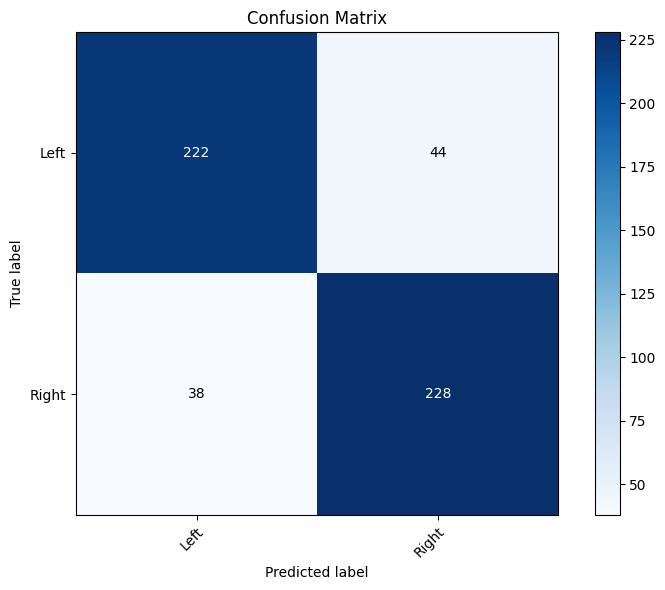

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np

X_flat = X_anova




# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train classifier
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot confusion matrix using matplotlib only
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set tick labels
classes = le.classes_
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel="Predicted label",
    ylabel="True label",
    title="Confusion Matrix"
)

# Rotate tick labels and align
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

Random Forest With mrmr

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Classification Report:
              precision    recall  f1-score   support

        Left       0.89      0.82      0.85       266
       Right       0.84      0.89      0.86       266

    accuracy                           0.86       532
   macro avg       0.86      0.86      0.86       532
weighted avg       0.86      0.86      0.86       532



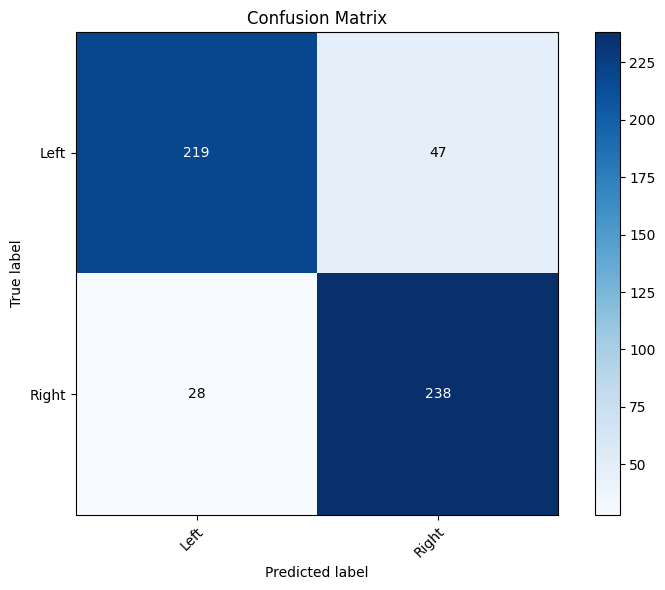

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
features_flat = features.reshape(features.shape[0], -1)
selected_mrmr_indices, _ = mrmr_selection(features_flat, y_encoded, K=30)
X_mrmr = features_flat[:, selected_mrmr_indices]

X_flat = X_mrmr






# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train classifier
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot confusion matrix using matplotlib only
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set tick labels
classes = le.classes_
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel="Predicted label",
    ylabel="True label",
    title="Confusion Matrix"
)

# Rotate tick labels and align
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

**SVM**

With mrmr

Classification Report:
              precision    recall  f1-score   support

        Left       0.73      0.52      0.61       266
       Right       0.63      0.81      0.71       266

    accuracy                           0.67       532
   macro avg       0.68      0.67      0.66       532
weighted avg       0.68      0.67      0.66       532



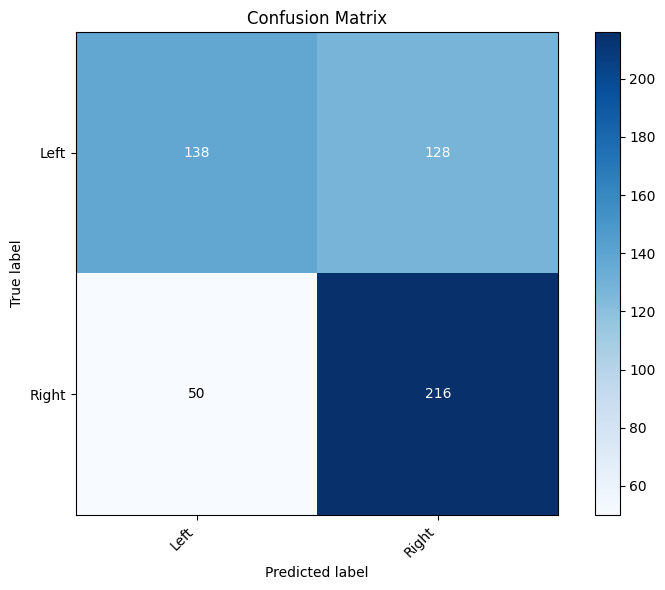

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

X_flat = X_mrmr  # Or X_anova if you're testing ANOVA instead


# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train SVM
clf = SVC(kernel='rbf', C=1, gamma='scale')  # You can try 'linear' or 'poly' too
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(le.classes_)),
    yticks=np.arange(len(le.classes_)),
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    xlabel="Predicted label",
    ylabel="True label",
    title="Confusion Matrix"
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

With ANOVA

Classification Report:
              precision    recall  f1-score   support

        Left       0.77      0.75      0.76       266
       Right       0.76      0.78      0.77       266

    accuracy                           0.76       532
   macro avg       0.76      0.76      0.76       532
weighted avg       0.76      0.76      0.76       532



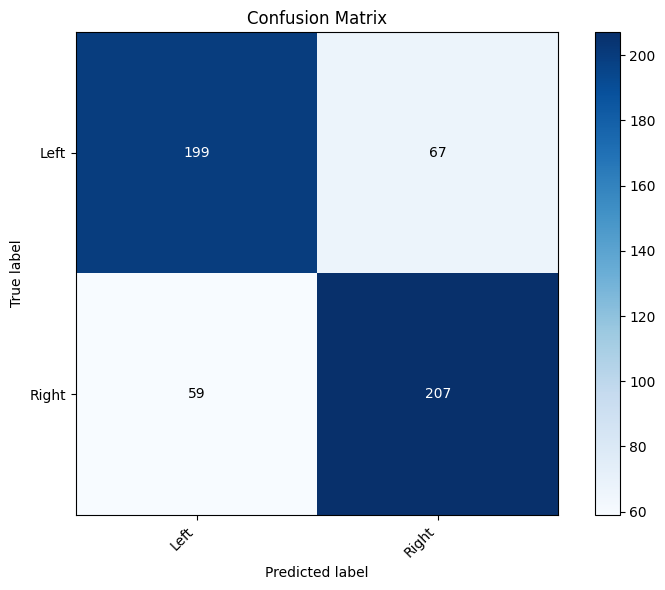

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

X_flat = X_anova


# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train SVM
clf = SVC(kernel='rbf', C=1, gamma='scale')  # You can try 'linear' or 'poly' too
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(le.classes_)),
    yticks=np.arange(len(le.classes_)),
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    xlabel="Predicted label",
    ylabel="True label",
    title="Confusion Matrix"
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

**RVOTFREEWALL & LVOTSUBVULAR**

In [ ]:
!pip install --upgrade scipy scikit-learn --quiet


In [ ]:
import pickle
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

# 📂 Load the full dataset (all_points_data)
with open("/content/drive/Shared drives/CompBiomedSemis/DL-RAW DATA/all_points_may_2024.pkl", "rb") as f:
    all_points_data = pickle.load(f)

# ✅ Define ECG leads and metadata keys
ecg_leads = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
metadata_keys = ['Sex', 'HTA', 'Age', 'PVC_transition', 'SOO_chamber', 'Height', 'Weight', 'BMI',
                 'DM', 'DLP', 'Smoker', 'COPD', 'Sleep_apnea', 'CLINICAL_SCORE', 'SOO', 'OTorigin']

# 🔁 Define binary encoding map
binary_map = {
    'Sex': {'M': 1, 'F': 0},
    'HTA': {'Yes': 1, 'No': 0},
    'DM': {'Yes': 1, 'No': 0},
    'DLP': {'Yes': 1, 'No': 0},
    'Smoker': {'Yes': 1, 'No': 0},
    'COPD': {'Yes': 1, 'No': 0},
    'Sleep_apnea': {'Yes': 1, 'No': 0}
}

# 🧠 Load SOO → Region_Simplified label mapping
labels_df = pd.read_excel("/content/drive/Shared drives/CompBiomedSemis/code files/labels_FontiersUnsupervised.xlsx", sheet_name="Hoja1")
label_map = dict(zip(labels_df["SOO"], labels_df["Region_Simplified"]))

print(" Data and label map loaded.")


 Data and label map loaded.


In [ ]:
# 🚩 Define your Task 2 target labels
target_labels_task2 = {'RVOTFREEWALL', 'LVOTSUBVALVULAR'}

# ⚙️ Control how many ECGs to extract per patient
max_ecgs_lvot = 200
max_ecgs_rvot = 10

structured_data_task2 = []

for patient_id, info in all_points_data.items():
    # Get original SOO and map to simplified label
    raw_label = info.get('SOO', [None])[0]
    mapped_label = label_map.get(raw_label, 'Unknown')

    # Skip if not in target labels
    if mapped_label not in target_labels_task2:
        continue

    # Extract metadata
    patient_metadata = {}
    for key in metadata_keys:
        val = info.get(key, [None])[0]
        if pd.isna(val):
            patient_metadata[key] = -1
        elif key in binary_map:
            patient_metadata[key] = binary_map[key].get(val, -1)
        else:
            patient_metadata[key] = val

    try:
        structures = list(info['Structures'].values())[0]
        ecg_count = 0
        max_allowed = max_ecgs_lvot if mapped_label == 'LVOTSUBVALVULAR' else max_ecgs_rvot

        for ecg_id, leads_dict in structures.items():
            if ecg_count >= max_allowed:
                break
            if len(leads_dict) == 12 and all(lead in leads_dict for lead in ecg_leads):
                ecg = {lead: leads_dict[lead] for lead in ecg_leads}
                structured_data_task2.append({
                    'ecg': ecg,
                    'label': mapped_label,
                    'metadata': patient_metadata
                })
                ecg_count += 1
    except:
        continue

# ✅ Show result summary
print("Total structured samples (Task 2):", len(structured_data_task2))
print("Label distribution (Task 2):", Counter([p['label'] for p in structured_data_task2]))


Total structured samples (Task 2): 391
Label distribution (Task 2): Counter({'RVOTFREEWALL': 358, 'LVOTSUBVALVULAR': 33})


In [ ]:
import numpy as np

# Convert ECGs into numpy arrays of shape (samples, 12, signal_length)
X_task2 = np.array([
    np.array([entry['ecg'][lead] for lead in ecg_leads])
    for entry in structured_data_task2
])

# Extract corresponding labels
y_task2 = np.array([entry['label'] for entry in structured_data_task2])

print("X_task2 shape:", X_task2.shape)
print("Label distribution:", Counter(y_task2))


X_task2 shape: (391, 12, 2500)
Label distribution: Counter({np.str_('RVOTFREEWALL'): 358, np.str_('LVOTSUBVALVULAR'): 33})


In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

# Convert labels to Series for indexing
y_series_task2 = pd.Series(y_task2)

# Class counts
counts = Counter(y_series_task2)
min_class = min(counts, key=counts.get)
max_class = max(counts, key=counts.get)
n_to_add = counts[max_class] - counts[min_class]

print(f"🔍 Augmenting class '{min_class}' with {n_to_add} synthetic samples...")

# Find indices of the minority class
minority_indices = y_series_task2[y_series_task2 == min_class].index
np.random.seed(42)
aug_indices = np.random.choice(minority_indices, size=n_to_add, replace=True)

# ---------- AUGMENTATION FUNCTIONS ----------
def time_shift(ecg, max_shift=20):
    shift = np.random.randint(-max_shift, max_shift + 1)
    return np.roll(ecg, shift, axis=1)

def amplitude_scale(ecg, scale_range=(0.9, 1.1)):
    factor = np.random.uniform(*scale_range)
    return ecg * factor

def add_noise(ecg, noise_level=0.005):
    noise = np.random.normal(0, noise_level, ecg.shape)
    return ecg + noise

# ---------- APPLY MIXED AUGMENTATION ----------
X_aug_task2 = []
for idx in aug_indices:
    ecg = X_task2[idx].copy()

    # Randomly select augmentation method
    method = np.random.choice(['shift', 'scale', 'noise'])
    if method == 'shift':
        ecg = time_shift(ecg)
    elif method == 'scale':
        ecg = amplitude_scale(ecg)
    else:
        ecg = add_noise(ecg)

    X_aug_task2.append(ecg)

X_aug_task2 = np.stack(X_aug_task2)

# Combine original + augmented data
X_balanced_task2 = np.concatenate([X_task2, X_aug_task2], axis=0)
y_balanced_task2 = np.concatenate([y_task2, [min_class] * n_to_add])

# Final check
print(f"Balanced shape: {X_balanced_task2.shape}")
print("Balanced distribution:", Counter(y_balanced_task2))



🔍 Augmenting class 'LVOTSUBVALVULAR' with 325 synthetic samples...
Balanced shape: (716, 12, 2500)
Balanced distribution: Counter({np.str_('RVOTFREEWALL'): 358, np.str_('LVOTSUBVALVULAR'): 358})


In [ ]:
!pip install biosppy peakutils


In [ ]:
import numpy as np
from biosppy.signals import ecg
import tqdm

def extract_features_from_lead(signal, fs=500):
    try:
        out = ecg.ecg(signal=signal, sampling_rate=fs, show=False)
        r_peaks = out['rpeaks']

        if len(r_peaks) < 3:
            return None  # not enough beats

        features = []
        for i in range(len(r_peaks) - 1):
            r1, r2 = r_peaks[i], r_peaks[i + 1]
            segment = signal[r1:r2]
            if len(segment) < 5:
                continue

            beat_features = {
                'RR': (r2 - r1) / fs,
                'mean': np.mean(segment),
                'std': np.std(segment),
                'min': np.min(segment),
                'max': np.max(segment),
                'ptp': np.ptp(segment),
                'median': np.median(segment),
                'q1': np.percentile(segment, 25),
                'q3': np.percentile(segment, 75),
                'abs_mean': np.mean(np.abs(segment)),
                'abs_max': np.max(np.abs(segment)),
                'abs_min': np.min(np.abs(segment)),
                'var': np.var(segment),
            }
            features.append(list(beat_features.values()))

        if not features:
            return None

        feats = np.array(features)
        return np.concatenate([feats.mean(axis=0), feats.std(axis=0)])

    except Exception:
        return None


# Apply feature extraction
all_features = []
failed = 0

for ecg_sample in tqdm.tqdm(X_balanced_task2):
    sample_features = []

    for lead in ecg_sample:
        feats = extract_features_from_lead(lead)
        if feats is None:
            sample_features.append(np.zeros(26))
            failed += 1
        else:
            sample_features.append(feats)

    all_features.append(sample_features)

features_task2 = np.array(all_features)
labels_task2 = y_balanced_task2

print(f"\nFeature array shape: {features_task2.shape}")
print(f"Failed lead extractions (replaced with zeros): {failed}")


100%|██████████| 716/716 [07:00<00:00,  1.70it/s]


Feature array shape: (716, 12, 26)
Failed lead extractions (replaced with zeros): 1754


In [ ]:
!pip install --upgrade scipy


In [ ]:
!pip install pingouin --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.1 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade scikit-learn --quiet


In [ ]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Flatten ECG features
features_flat_task2 = features_task2.reshape(features_task2.shape[0], -1)
le = LabelEncoder()
y_encoded_task2 = le.fit_transform(labels_task2)

# Compute F-scores
f_scores, _ = f_classif(features_flat_task2, y_encoded_task2)

# Select top K
K = 30
top_k = np.argsort(f_scores)[::-1][:K]
X_anova_task2 = features_flat_task2[:, top_k]

print("ANOVA features shape:", X_anova_task2.shape)


ANOVA features shape: (716, 30)


In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import numpy as np

def mrmr_selection(X, y, K):
    selected = []
    n_features = X.shape[1]
    feature_indices = list(range(n_features))

    # Mutual information (relevance)
    relevance = mutual_info_classif(X, y)

    # Start with the most relevant
    first_idx = np.argmax(relevance)
    selected.append(first_idx)
    feature_indices.remove(first_idx)

    for _ in range(1, K):
        scores = []
        for idx in feature_indices:
            rel = relevance[idx]
            redundancy = np.mean([
                np.nan_to_num(np.abs(np.corrcoef(X[:, idx], X[:, sel])[0, 1]), nan=0.0)
                for sel in selected
            ])
            scores.append(rel - redundancy)
        next_idx = feature_indices[np.argmax(scores)]
        selected.append(next_idx)
        feature_indices.remove(next_idx)

    return selected, relevance

# Flatten features and encode labels
features_flat_task2 = features_task2.reshape(features_task2.shape[0], -1)
le = LabelEncoder()
y_encoded_task2 = le.fit_transform(labels_task2)

# Apply mRMR
K = 30
selected_mrmr, rel_mrmr = mrmr_selection(features_flat_task2, y_encoded_task2, K)
X_mrmr_task2 = features_flat_task2[:, selected_mrmr]

print("mRMR selected top feature indices:", selected_mrmr)
print("mRMR features shape:", X_mrmr_task2.shape)


mRMR selected top feature indices: [np.int64(160), 143, 112, 183, 26, 163, 185, 290, 65, 3, 156, 221, 107, 209, 208, 287, 190, 166, 39, 105, 286, 214, 161, 38, 130, 195, 168, 188, 52, 211]
mRMR features shape: (716, 30)


Classification Report (ANOVA):
                 precision    recall  f1-score   support

LVOTSUBVALVULAR       0.96      0.99      0.97        72
   RVOTFREEWALL       0.99      0.96      0.97        72

       accuracy                           0.97       144
      macro avg       0.97      0.97      0.97       144
   weighted avg       0.97      0.97      0.97       144



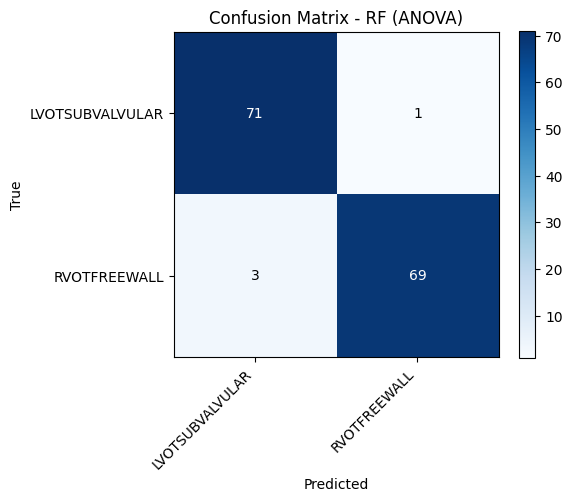

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Encode labels
le = LabelEncoder()
y_encoded_task2 = le.fit_transform(labels_task2)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_anova_task2, y_encoded_task2, test_size=0.2, random_state=42, stratify=y_encoded_task2
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict & Evaluate
y_pred = clf.predict(X_test_scaled)

print("Classification Report (ANOVA):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(le.classes_)),
    yticks=np.arange(len(le.classes_)),
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    xlabel='Predicted',
    ylabel='True',
    title='Confusion Matrix - RF (ANOVA)'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


Classification Report (mRMR):
                 precision    recall  f1-score   support

LVOTSUBVALVULAR       0.99      0.97      0.98        72
   RVOTFREEWALL       0.97      0.99      0.98        72

       accuracy                           0.98       144
      macro avg       0.98      0.98      0.98       144
   weighted avg       0.98      0.98      0.98       144



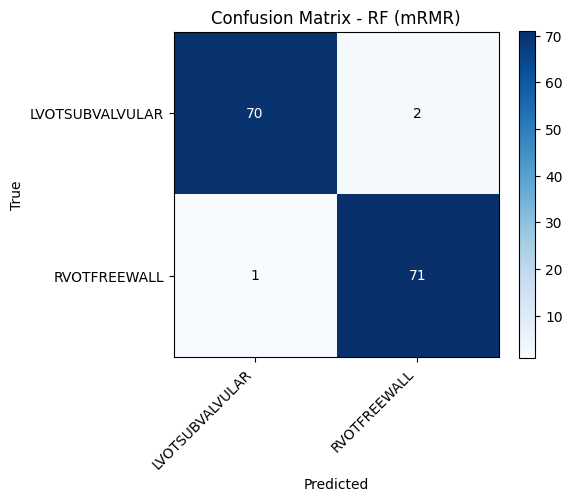

In [ ]:
# Use the same encoded labels
X_train, X_test, y_train, y_test = train_test_split(
    X_mrmr_task2, y_encoded_task2, test_size=0.2, random_state=42, stratify=y_encoded_task2
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict & Evaluate
y_pred = clf.predict(X_test_scaled)

print("Classification Report (mRMR):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(le.classes_)),
    yticks=np.arange(len(le.classes_)),
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    xlabel='Predicted',
    ylabel='True',
    title='Confusion Matrix - RF (mRMR)'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


SVM Classification Report (ANOVA):
                 precision    recall  f1-score   support

LVOTSUBVALVULAR       0.94      0.94      0.94        72
   RVOTFREEWALL       0.94      0.94      0.94        72

       accuracy                           0.94       144
      macro avg       0.94      0.94      0.94       144
   weighted avg       0.94      0.94      0.94       144



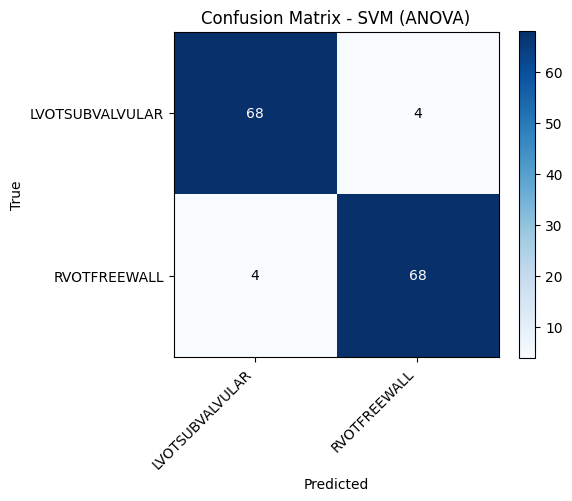

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_anova_task2, y_encoded_task2, test_size=0.2, random_state=42, stratify=y_encoded_task2
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM
clf = SVC(kernel='rbf', C=1, gamma='scale')
clf.fit(X_train_scaled, y_train)

# Predict
y_pred = clf.predict(X_test_scaled)

# Evaluate
print("SVM Classification Report (ANOVA):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(le.classes_)),
    yticks=np.arange(len(le.classes_)),
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    xlabel='Predicted',
    ylabel='True',
    title='Confusion Matrix - SVM (ANOVA)'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

SVM Classification Report (mRMR):
                 precision    recall  f1-score   support

LVOTSUBVALVULAR       0.99      0.96      0.97        72
   RVOTFREEWALL       0.96      0.99      0.97        72

       accuracy                           0.97       144
      macro avg       0.97      0.97      0.97       144
   weighted avg       0.97      0.97      0.97       144



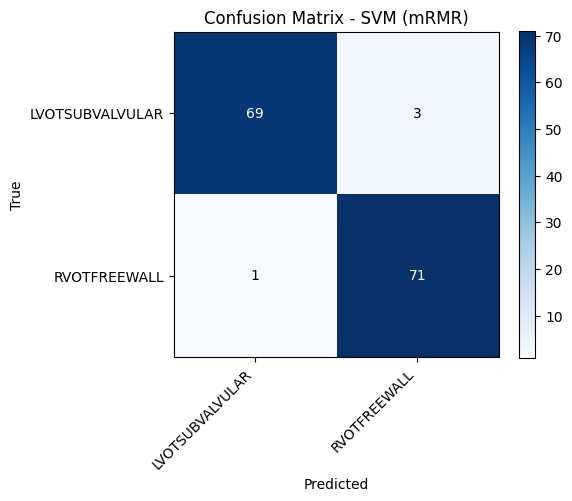

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_mrmr_task2, y_encoded_task2, test_size=0.2, random_state=42, stratify=y_encoded_task2
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM
clf = SVC(kernel='rbf', C=1, gamma='scale')
clf.fit(X_train_scaled, y_train)

# Predict
y_pred = clf.predict(X_test_scaled)

# Evaluate
print("SVM Classification Report (mRMR):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(le.classes_)),
    yticks=np.arange(len(le.classes_)),
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    xlabel='Predicted',
    ylabel='True',
    title='Confusion Matrix - SVM (mRMR)'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


**Modelo antiguo**

In [ ]:
from collections import Counter
label_counts = Counter([p['label'] for p in structured_data])
print("Available label values:", label_counts)


Available label values: Counter({'LVOT': 440, 'RVOT': 284, 'Right ventricle': 203, 'Mitral annulus': 56, 'Left ventricle': 42, 'Coronary sinus': 32, 'Tricuspid annulus': 24})


In [ ]:
target_labels_task2 = {'RVOT', 'LVOT'}
filtered_data_task2 = [
    patient for patient in structured_data
    if patient['label'] in target_labels_task2
]

print(f"Total samples for Task 2: {len(filtered_data_task2)}")
print("Label distribution for Task 2:", Counter([p['label'] for p in filtered_data_task2]))


Total samples for Task 2: 724
Label distribution for Task 2: Counter({'LVOT': 440, 'RVOT': 284})


In [ ]:
ecg_leads = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

X_task2 = np.array([
    np.array([patient['ecg'][lead] for lead in ecg_leads])
    for patient in filtered_data_task2
])

y_task2 = [patient['label'] for patient in filtered_data_task2]


Feature Extraction

In [ ]:
import numpy as np
import tqdm
from scipy.signal import butter, filtfilt
from biosppy.signals import ecg

# Constants
fs = 500
REFRACTORY_PERIOD = 0.2  # 200 ms
QS_WINDOW = 0.04
P_WINDOW = 0.2
T_WINDOW = 0.4

def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=500, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    padlen = 3 * max(len(a), len(b))
    if len(signal) <= padlen:
        raise ValueError(f"Signal too short: len={len(signal)}, required > {padlen}")
    return filtfilt(b, a, signal)

def extract_features_with_reason_biosppy(ecg_signal, fs):
    try:
        filtered = bandpass_filter(ecg_signal, fs=fs)
        out = ecg.ecg(signal=filtered, sampling_rate=fs, show=False)
        r_peaks = out['rpeaks']
        if len(r_peaks) < 3:
            return None, "no_r_peaks"

        features = []
        signals_per_cycle = []

        for i in range(len(r_peaks) - 1):
            try:
                r = r_peaks[i]
                next_r = r_peaks[i + 1]
                segment = ecg_signal[r:next_r]

                q_window = int(QS_WINDOW * fs)
                q_index = max(r - q_window, 0)
                Q = q_index + np.argmin(ecg_signal[q_index:r])
                s_index = r + 1
                s_end = min(r + q_window, len(ecg_signal) - 1)
                S = s_index + np.argmin(ecg_signal[s_index:s_end])

                p_window = int(P_WINDOW * fs)
                p_start = max(Q - p_window, 0)
                if Q <= p_start:
                    continue
                P = p_start + np.argmax(ecg_signal[p_start:Q])

                t_window = int(T_WINDOW * fs)
                t_start = S
                t_end = min(S + t_window, len(ecg_signal))
                if t_end <= t_start:
                    continue
                T = t_start + np.argmax(ecg_signal[t_start:t_end])

                PR_int = (Q - P) / fs
                QRS_dur = (S - Q) / fs
                QT_int = (T - Q) / fs
                RR_int = (next_r - r) / fs

                AMP_P = ecg_signal[P]
                AMP_Q = ecg_signal[Q]
                AMP_R = ecg_signal[r]
                AMP_S = ecg_signal[S]
                AMP_T = ecg_signal[T]

                T_inverted = AMP_T < 0
                P_inverted = AMP_P < 0

                feat_vec = [PR_int, QRS_dur, QT_int, RR_int,
                            AMP_P, AMP_Q, AMP_R, AMP_S, AMP_T,
                            AMP_R / AMP_S if AMP_S != 0 else 0,
                            AMP_P / AMP_T if AMP_T != 0 else 0,
                            int(T_inverted), int(P_inverted)]

                features.append(feat_vec)
                signals_per_cycle.append(segment)
            except:
                continue

        if not features:
            return None, "no_valid_beats"

        # Most representative cycle
        min_len = min(len(seg) for seg in signals_per_cycle)
        truncated = [seg[:min_len] for seg in signals_per_cycle]
        matrix = np.stack(truncated)
        corr_matrix = np.corrcoef(matrix)
        corr_scores = np.mean(np.abs(corr_matrix), axis=1)
        max_rep_idx = np.argmax(corr_scores)

        return np.array([features[max_rep_idx]]), None

    except Exception as e:
        print(f"Exception in feature extraction: {e}")
        return None, "other"

def process_dataset(X, y, fs):
    all_features, all_labels, error_log = [], [], []
    reason_counts = {"no_r_peaks": 0, "bad_p_window": 0, "bad_t_window": 0, "no_valid_beats": 0, "other": 0}
    lead_failure_counts = {lead: 0 for lead in range(X.shape[1])}

    for i in tqdm.tqdm(range(len(X))):
        ecg = X[i]
        label = y[i]
        lead_features = []

        for lead_idx in range(ecg.shape[0]):
            signal = ecg[lead_idx]
            feats, reason = extract_features_with_reason_biosppy(signal, fs)

            if feats is None or feats.ndim != 2 or feats.shape[0] == 0:
                error_log.append((i, lead_idx))
                lead_failure_counts[lead_idx] += 1
                reason_counts[reason] += 1
                summary = np.zeros(26)
            else:
                summary = np.concatenate([feats.mean(axis=0), feats.std(axis=0)])
            lead_features.append(summary)

        all_features.append(lead_features)
        all_labels.append(label)

    print(f"\nFeature extraction failed on {len(error_log)} of {X.shape[0] * X.shape[1]} leads")
    print("Failure reasons:", reason_counts)
    print("Per-lead failures:", lead_failure_counts)
    return np.array(all_features), np.array(all_labels)


In [ ]:
features_task2, labels_task2 = process_dataset(X_task2, y_task2, fs)


  1%|          | 4/724 [00:01<04:59,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  1%|          | 5/724 [00:02<05:00,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  1%|          | 8/724 [00:03<04:56,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  1%|          | 9/724 [00:03<04:58,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  1%|▏         | 10/724 [00:04<04:55,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 11/724 [00:04<05:31,  2.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 12/724 [00:05<06:00,  1.97it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 13/724 [00:05<06:20,  1.87it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 14/724 [00:06<06:30,  1.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  2%|▏         | 15/724 [00:07<06:38,  1.78it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 19/724 [00:09<05:47,  2.03it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 20/724 [00:09<05:30,  2.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 21/724 [00:09<05:22,  2.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 22/724 [00:10<05:14,  2.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 23/724 [00:10<05:06,  2.29it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  3%|▎         | 24/724 [00:11<05:01,  2.32it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▎         | 26/724 [00:12<04:55,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▎         | 27/724 [00:12<04:52,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  4%|▍         | 31/724 [00:14<04:47,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 33/724 [00:14<04:41,  2.45it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 34/724 [00:15<04:45,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 35/724 [00:15<04:42,  2.44it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▍         | 36/724 [00:16<04:41,  2.44it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▌         | 37/724 [00:16<04:41,  2.44it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▌         | 38/724 [00:16<04:41,  2.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  5%|▌         | 39/724 [00:17<04:42,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 40/724 [00:17<04:41,  2.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 41/724 [00:18<04:51,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 42/724 [00:18<05:22,  2.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 43/724 [00:19<05:46,  1.96it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 44/724 [00:20<06:01,  1.88it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▌         | 45/724 [00:20<06:13,  1.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▋         | 46/724 [00:21<06:18,  1.79it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  6%|▋         | 47/724 [00:21<06:28,  1.74it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 48/724 [00:22<06:04,  1.85it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 49/724 [00:22<05:42,  1.97it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 50/724 [00:23<05:21,  2.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 51/724 [00:23<05:11,  2.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 52/724 [00:23<05:00,  2.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 53/724 [00:24<04:51,  2.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  7%|▋         | 54/724 [00:24<04:50,  2.31it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 55/724 [00:25<04:43,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 56/724 [00:25<04:45,  2.34it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 58/724 [00:26<04:35,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  8%|▊         | 60/724 [00:27<04:31,  2.44it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▊         | 62/724 [00:28<04:31,  2.44it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▊         | 63/724 [00:28<04:31,  2.44it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


  9%|▉         | 67/724 [00:30<04:30,  2.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 10%|▉         | 69/724 [00:30<04:31,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 73/724 [00:32<05:14,  2.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 74/724 [00:33<05:33,  1.95it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 75/724 [00:34<05:46,  1.87it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 10%|█         | 76/724 [00:34<05:54,  1.83it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█         | 77/724 [00:35<06:02,  1.78it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█         | 79/724 [00:36<05:40,  1.89it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█         | 80/724 [00:36<05:17,  2.03it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█         | 81/724 [00:37<05:00,  2.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█▏        | 82/724 [00:37<04:50,  2.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 11%|█▏        | 83/724 [00:37<04:42,  2.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 84/724 [00:38<04:38,  2.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 85/724 [00:38<04:32,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 86/724 [00:39<04:27,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 88/724 [00:39<04:28,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 89/724 [00:40<04:26,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 12%|█▏        | 90/724 [00:40<04:24,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 14%|█▍        | 100/724 [00:44<04:18,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 14%|█▍        | 104/724 [00:46<05:08,  2.01it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 15%|█▍        | 106/724 [00:48<05:35,  1.84it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 15%|█▍        | 107/724 [00:48<05:47,  1.78it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 15%|█▌        | 109/724 [00:49<05:46,  1.78it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 15%|█▌        | 110/724 [00:50<05:16,  1.94it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 15%|█▌        | 111/724 [00:50<04:56,  2.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 15%|█▌        | 112/724 [00:51<04:47,  2.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 17%|█▋        | 126/724 [00:56<04:07,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 128/724 [00:57<04:08,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 18%|█▊        | 130/724 [00:58<04:08,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 20%|█▉        | 144/724 [01:05<04:23,  2.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 20%|██        | 146/724 [01:06<04:08,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 21%|██        | 150/724 [01:08<04:01,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 21%|██        | 151/724 [01:08<04:01,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 21%|██▏       | 154/724 [01:09<04:02,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 21%|██▏       | 155/724 [01:10<04:01,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 22%|██▏       | 156/724 [01:10<04:00,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 22%|██▏       | 157/724 [01:11<04:00,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 22%|██▏       | 159/724 [01:11<03:58,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 23%|██▎       | 166/724 [01:15<05:01,  1.85it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 24%|██▍       | 176/724 [01:20<03:59,  2.29it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▌       | 186/724 [01:24<03:43,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▌       | 188/724 [01:25<03:41,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▌       | 189/724 [01:25<03:43,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 26%|██▋       | 191/724 [01:26<03:43,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 192/724 [01:26<03:41,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 193/724 [01:27<03:40,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 194/724 [01:27<04:08,  2.13it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 195/724 [01:28<04:25,  2.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 196/724 [01:29<04:40,  1.88it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 27%|██▋       | 197/724 [01:29<04:49,  1.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 202/724 [01:32<04:14,  2.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 204/724 [01:33<03:55,  2.21it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 205/724 [01:33<03:48,  2.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 28%|██▊       | 206/724 [01:33<03:45,  2.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 209/724 [01:35<03:40,  2.34it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 210/724 [01:35<03:37,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 211/724 [01:35<03:38,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 29%|██▉       | 212/724 [01:36<03:36,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 30%|██▉       | 214/724 [01:37<03:33,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 30%|██▉       | 215/724 [01:37<03:32,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 30%|██▉       | 217/724 [01:38<03:32,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███       | 222/724 [01:40<03:31,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███       | 223/724 [01:41<03:28,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███       | 224/724 [01:41<03:46,  2.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███       | 225/724 [01:42<04:09,  2.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 31%|███▏      | 228/724 [01:43<04:33,  1.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 229/724 [01:44<04:41,  1.76it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 230/724 [01:45<04:39,  1.77it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 231/724 [01:45<04:17,  1.92it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 232/724 [01:45<03:58,  2.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 32%|███▏      | 233/724 [01:46<03:47,  2.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 33%|███▎      | 237/724 [01:48<03:31,  2.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 33%|███▎      | 238/724 [01:48<03:27,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 33%|███▎      | 239/724 [01:48<03:26,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 33%|███▎      | 240/724 [01:49<03:24,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 33%|███▎      | 241/724 [01:49<03:23,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 33%|███▎      | 242/724 [01:50<03:20,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▎      | 243/724 [01:50<03:18,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 245/724 [01:51<03:22,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 34%|███▍      | 249/724 [01:53<03:17,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 35%|███▍      | 250/724 [01:53<03:16,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 35%|███▍      | 252/724 [01:54<03:16,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 35%|███▍      | 253/724 [01:54<03:14,  2.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 35%|███▌      | 254/724 [01:55<03:24,  2.30it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 35%|███▌      | 255/724 [01:55<03:48,  2.05it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 36%|███▌      | 259/724 [01:58<04:28,  1.73it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 36%|███▌      | 261/724 [01:59<04:07,  1.87it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 36%|███▌      | 262/724 [01:59<03:50,  2.00it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 36%|███▋      | 263/724 [02:00<03:37,  2.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 37%|███▋      | 265/724 [02:00<03:24,  2.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 37%|███▋      | 266/724 [02:01<03:20,  2.28it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 37%|███▋      | 267/724 [02:01<03:16,  2.32it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 37%|███▋      | 269/724 [02:02<03:11,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 37%|███▋      | 270/724 [02:02<03:08,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 37%|███▋      | 271/724 [02:03<03:10,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 38%|███▊      | 272/724 [02:03<03:08,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 38%|███▊      | 273/724 [02:04<03:05,  2.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 38%|███▊      | 277/724 [02:05<03:06,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 39%|███▉      | 285/724 [02:09<03:27,  2.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 40%|████      | 291/724 [02:12<03:58,  1.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 40%|████      | 292/724 [02:13<03:37,  1.98it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 40%|████      | 293/724 [02:13<03:26,  2.08it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 294/724 [02:14<03:17,  2.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 297/724 [02:15<03:02,  2.34it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████      | 298/724 [02:15<02:59,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 41%|████▏     | 300/724 [02:16<02:57,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 302/724 [02:17<02:55,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 303/724 [02:17<02:54,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 306/724 [02:19<02:56,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 42%|████▏     | 307/724 [02:19<02:54,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 43%|████▎     | 313/724 [02:21<02:49,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 43%|████▎     | 314/724 [02:22<02:49,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 44%|████▍     | 320/724 [02:25<03:49,  1.76it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 44%|████▍     | 322/724 [02:26<03:33,  1.88it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 46%|████▋     | 336/724 [02:32<02:43,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 337/724 [02:33<02:41,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 338/724 [02:33<02:41,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 340/724 [02:34<02:40,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 341/724 [02:34<02:40,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 47%|████▋     | 342/724 [02:35<02:39,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 344/724 [02:36<02:39,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 346/724 [02:37<03:00,  2.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 347/724 [02:37<03:13,  1.95it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 48%|████▊     | 351/724 [02:40<03:38,  1.71it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 49%|████▊     | 352/724 [02:40<03:22,  1.84it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 49%|████▉     | 354/724 [02:41<02:57,  2.09it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 49%|████▉     | 355/724 [02:41<02:50,  2.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 50%|█████     | 364/724 [02:45<02:30,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 368/724 [02:47<02:27,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 369/724 [02:47<02:27,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 51%|█████     | 371/724 [02:48<02:26,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 54%|█████▍    | 394/724 [02:59<02:18,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 55%|█████▍    | 395/724 [02:59<02:18,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 55%|█████▍    | 396/724 [03:00<02:17,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 55%|█████▍    | 398/724 [03:00<02:15,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 55%|█████▌    | 399/724 [03:01<02:16,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 55%|█████▌    | 401/724 [03:02<02:15,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 57%|█████▋    | 416/724 [03:09<02:22,  2.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 58%|█████▊    | 420/724 [03:11<02:09,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 58%|█████▊    | 423/724 [03:12<02:08,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▊    | 424/724 [03:13<02:05,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 426/724 [03:13<02:05,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 427/724 [03:14<02:04,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 59%|█████▉    | 429/724 [03:15<02:02,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 450/724 [03:25<01:55,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 451/724 [03:25<01:54,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 62%|██████▏   | 452/724 [03:25<01:53,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 63%|██████▎   | 455/724 [03:27<01:50,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 463/724 [03:30<01:49,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 464/724 [03:30<01:48,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 64%|██████▍   | 466/724 [03:31<01:47,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 65%|██████▍   | 468/724 [03:32<02:08,  1.99it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 65%|██████▍   | 469/724 [03:33<02:15,  1.88it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 65%|██████▌   | 473/724 [03:35<02:22,  1.76it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▌   | 475/724 [03:36<02:00,  2.06it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▌   | 476/724 [03:37<01:55,  2.15it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▌   | 477/724 [03:37<01:51,  2.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▌   | 478/724 [03:37<01:48,  2.27it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 66%|██████▋   | 480/724 [03:38<01:43,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 482/724 [03:39<01:41,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 67%|██████▋   | 488/724 [03:42<01:37,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 68%|██████▊   | 494/724 [03:44<01:35,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▊   | 496/724 [03:45<01:34,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 500/724 [03:47<02:02,  1.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 502/724 [03:48<02:07,  1.75it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 69%|██████▉   | 503/724 [03:49<02:09,  1.71it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 70%|██████▉   | 504/724 [03:49<01:56,  1.88it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 70%|██████▉   | 505/724 [03:50<01:49,  2.01it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 70%|██████▉   | 506/724 [03:50<01:43,  2.10it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 70%|███████   | 507/724 [03:51<01:38,  2.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 512/724 [03:53<01:29,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 514/724 [03:54<01:27,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████   | 515/724 [03:54<01:26,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 71%|███████▏  | 516/724 [03:54<01:27,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 72%|███████▏  | 518/724 [03:55<01:25,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 72%|███████▏  | 519/724 [03:56<01:24,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 72%|███████▏  | 520/724 [03:56<01:24,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 72%|███████▏  | 522/724 [03:57<01:23,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 72%|███████▏  | 523/724 [03:57<01:23,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 72%|███████▏  | 524/724 [03:58<01:23,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 73%|███████▎  | 525/724 [03:58<01:22,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 534/724 [04:03<01:44,  1.82it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 535/724 [04:03<01:35,  1.98it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 536/724 [04:04<01:30,  2.07it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 74%|███████▍  | 537/724 [04:04<01:26,  2.17it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▍  | 542/724 [04:06<01:17,  2.34it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▌  | 544/724 [04:07<01:17,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 75%|███████▌  | 545/724 [04:08<01:16,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 76%|███████▌  | 547/724 [04:08<01:14,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 76%|███████▌  | 548/724 [04:09<01:13,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 76%|███████▌  | 550/724 [04:10<01:12,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 76%|███████▌  | 552/724 [04:11<01:11,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 76%|███████▋  | 553/724 [04:11<01:10,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 77%|███████▋  | 554/724 [04:11<01:10,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 77%|███████▋  | 556/724 [04:12<01:10,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 77%|███████▋  | 557/724 [04:13<01:09,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 77%|███████▋  | 558/724 [04:13<01:16,  2.18it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 77%|███████▋  | 559/724 [04:14<01:23,  1.97it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 77%|███████▋  | 560/724 [04:14<01:28,  1.86it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 79%|███████▉  | 574/724 [04:21<01:02,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 80%|███████▉  | 576/724 [04:22<01:01,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 80%|████████  | 580/724 [04:23<00:59,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 80%|████████  | 581/724 [04:24<00:59,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 81%|████████  | 583/724 [04:25<00:58,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 81%|████████  | 584/724 [04:25<00:58,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 81%|████████  | 587/724 [04:26<00:57,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 81%|████████  | 588/724 [04:27<01:00,  2.25it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 83%|████████▎ | 604/724 [04:35<00:50,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 84%|████████▍ | 607/724 [04:36<00:49,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 84%|████████▍ | 610/724 [04:37<00:47,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 85%|████████▍ | 612/724 [04:38<00:46,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 85%|████████▍ | 613/724 [04:38<00:46,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 85%|████████▍ | 614/724 [04:39<00:45,  2.43it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 85%|████████▍ | 615/724 [04:39<00:45,  2.42it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 85%|████████▌ | 618/724 [04:40<00:43,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 85%|████████▌ | 619/724 [04:41<00:48,  2.16it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 86%|████████▌ | 622/724 [04:43<00:55,  1.83it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 86%|████████▋ | 625/724 [04:44<00:55,  1.79it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 87%|████████▋ | 630/724 [04:47<00:41,  2.24it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 646/724 [04:53<00:32,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 89%|████████▉ | 647/724 [04:54<00:31,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 90%|████████▉ | 649/724 [04:54<00:32,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 90%|█████████ | 653/724 [04:57<00:39,  1.81it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 90%|█████████ | 654/724 [04:57<00:39,  1.78it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 90%|█████████ | 655/724 [04:58<00:39,  1.73it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 656/724 [04:59<00:36,  1.86it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 657/724 [04:59<00:33,  2.01it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 658/724 [04:59<00:31,  2.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████ | 659/724 [05:00<00:29,  2.20it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████▏| 661/724 [05:01<00:27,  2.31it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 91%|█████████▏| 662/724 [05:01<00:26,  2.32it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 92%|█████████▏| 663/724 [05:01<00:25,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 92%|█████████▏| 664/724 [05:02<00:25,  2.35it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 92%|█████████▏| 665/724 [05:02<00:24,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 92%|█████████▏| 666/724 [05:03<00:24,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 92%|█████████▏| 667/724 [05:03<00:24,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 92%|█████████▏| 668/724 [05:03<00:23,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 92%|█████████▏| 669/724 [05:04<00:22,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▍| 687/724 [05:13<00:18,  1.97it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 95%|█████████▌| 691/724 [05:14<00:14,  2.29it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▌| 693/724 [05:15<00:13,  2.33it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▌| 695/724 [05:16<00:12,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▌| 696/724 [05:16<00:11,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▋| 697/724 [05:17<00:11,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 96%|█████████▋| 698/724 [05:17<00:11,  2.34it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 699/724 [05:18<00:10,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 700/724 [05:18<00:10,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 701/724 [05:19<00:09,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 703/724 [05:19<00:08,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 704/724 [05:20<00:08,  2.40it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 97%|█████████▋| 705/724 [05:20<00:07,  2.41it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 706/724 [05:21<00:07,  2.39it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 707/724 [05:21<00:07,  2.38it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 708/724 [05:21<00:06,  2.36it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 709/724 [05:22<00:06,  2.37it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 710/724 [05:22<00:06,  2.14it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 98%|█████████▊| 711/724 [05:23<00:06,  1.97it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 99%|█████████▉| 715/724 [05:26<00:05,  1.72it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 99%|█████████▉| 716/724 [05:26<00:04,  1.75it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


 99%|█████████▉| 719/724 [05:27<00:02,  2.12it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.


 99%|█████████▉| 720/724 [05:28<00:01,  2.22it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


100%|█████████▉| 721/724 [05:28<00:01,  2.23it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


100%|█████████▉| 722/724 [05:29<00:00,  2.29it/s]

Exception in feature extraction: Not enough beats to compute heart rate.


100%|██████████| 724/724 [05:29<00:00,  2.19it/s]

Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.
Exception in feature extraction: Not enough beats to compute heart rate.

Feature extraction failed on 2585 of 8688 leads
Failure reasons: {'no_r_peaks': 1856, 'bad_p_window': 0, 'bad_t_window': 0, 'no_valid_beats': 0, 'other': 729}
Per-lead failures: {0: 239, 1: 221, 2: 220, 3: 218, 4: 197, 5: 230, 6: 185, 7: 243, 8: 218, 9: 205, 10: 199, 11: 210}


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Flatten features to (samples, features)
features_flat_task2 = features.reshape(features.shape[0], -1)

# Encode labels
from sklearn.preprocessing import LabelEncoder
le_task2 = LabelEncoder()
y_encoded_task2 = le_task2.fit_transform(labels)

# Confirm shape
print("Features shape:", features_flat_task2.shape)
print("Encoded labels:", set(y_encoded_task2))


Features shape: (1086, 312)
Encoded labels: {np.int64(0), np.int64(1)}


Feature Selection

ANOVA

In [ ]:
from sklearn.feature_selection import f_classif, VarianceThreshold

def anova_selection(X, y, K):
    vt = VarianceThreshold(threshold=0.0)
    X_var = vt.fit_transform(X)
    kept_indices = vt.get_support(indices=True)

    f_scores, _ = f_classif(X_var, y)
    top_k_in_var = np.argsort(f_scores)[::-1][:K]
    selected = kept_indices[top_k_in_var]

    return selected.tolist(), f_scores, kept_indices

# Run ANOVA
K = 30
selected_anova, f_scores_anova, kept_indices_anova = anova_selection(features_flat_task2, y_encoded_task2, K)
X_anova_task2 = features_flat_task2[:, selected_anova]

print(f"ANOVA: Selected top {K} feature indices:", selected_anova)


ANOVA: Selected top 30 feature indices: [236, 263, 262, 237, 261, 235, 289, 264, 287, 241, 159, 158, 267, 246, 272, 290, 238, 260, 291, 157, 292, 220, 82, 105, 6, 107, 242, 266, 189, 130]


MRMR

In [ ]:
from sklearn.feature_selection import mutual_info_classif

def mrmr_selection(X, y, K):
    selected = []
    n_features = X.shape[1]
    feature_indices = list(range(n_features))
    relevance = mutual_info_classif(X, y)

    first_idx = np.argmax(relevance)
    selected.append(first_idx)
    feature_indices.remove(first_idx)

    for _ in range(1, K):
        mrmr_scores = []
        for idx in feature_indices:
            rel = relevance[idx]
            if rel == 0:
                mrmr_scores.append(-np.inf)
                continue
            redundancy_list = [
                np.nan_to_num(abs(np.corrcoef(X[:, idx], X[:, s])[0, 1]), nan=0.0)
                for s in selected
            ]
            red = np.mean(redundancy_list)
            score = rel - red
            mrmr_scores.append(score)

        if all(score == -np.inf for score in mrmr_scores):
            break

        next_idx = feature_indices[np.argmax(mrmr_scores)]
        selected.append(next_idx)
        feature_indices.remove(next_idx)

    return selected, relevance

# Run mRMR
selected_mrmr, relevance_mrmr = mrmr_selection(features_flat_task2, y_encoded_task2, K)
X_mrmr_task2 = features_flat_task2[:, selected_mrmr]

print(f"✅ mRMR: Selected top {K} feature indices:", selected_mrmr)


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


✅ mRMR: Selected top 30 feature indices: [np.int64(264), 243, 118, 260, 15, 269, 217, 267, 97, 178, 221, 188, 244, 310, 259, 189, 170, 268, 87, 284, 171, 70, 84, 139, 230, 19, 67, 50, 109, 199]


Training Models

Random Forest (ANOVA) Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       109
           1       0.84      0.86      0.85       109

    accuracy                           0.85       218
   macro avg       0.85      0.85      0.85       218
weighted avg       0.85      0.85      0.85       218



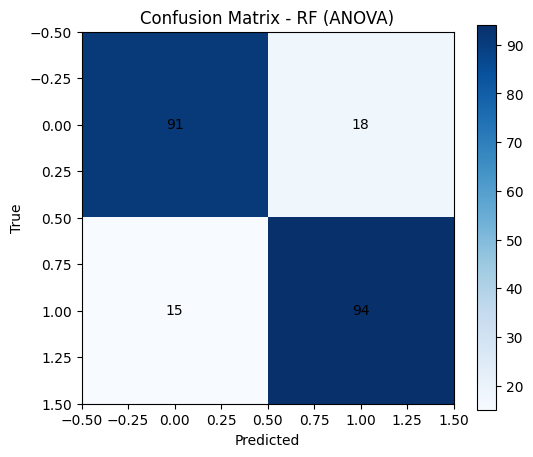

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_anova_task2, y_encoded_task2, test_size=0.2, random_state=42, stratify=y_encoded_task2
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train RF
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

# Evaluate
print("Random Forest (ANOVA) Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix - RF (ANOVA)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.show()


Random Forest (ANOVA) Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       109
           1       0.85      0.81      0.83       109

    accuracy                           0.83       218
   macro avg       0.84      0.83      0.83       218
weighted avg       0.84      0.83      0.83       218



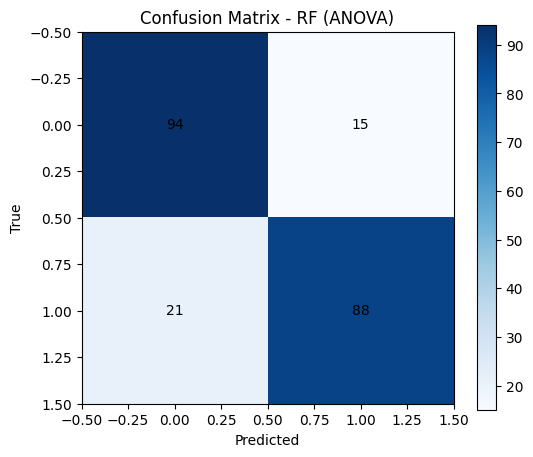

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_mrmr_task2, y_encoded_task2, test_size=0.2, random_state=42, stratify=y_encoded_task2
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train RF
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

# Evaluate
print("Random Forest (ANOVA) Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix - RF (ANOVA)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.show()


SVM

SVM Classification Report (ANOVA):
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       109
           1       0.71      0.73      0.72       109

    accuracy                           0.72       218
   macro avg       0.72      0.72      0.72       218
weighted avg       0.72      0.72      0.72       218



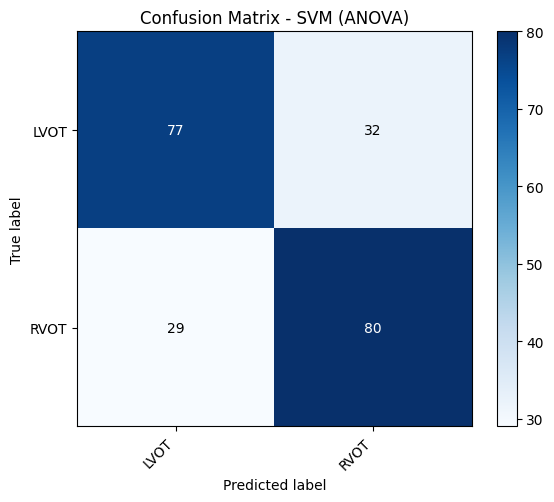

SVM Classification Report (mRMR):
              precision    recall  f1-score   support

           0       0.76      0.68      0.71       109
           1       0.71      0.78      0.74       109

    accuracy                           0.73       218
   macro avg       0.73      0.73      0.73       218
weighted avg       0.73      0.73      0.73       218



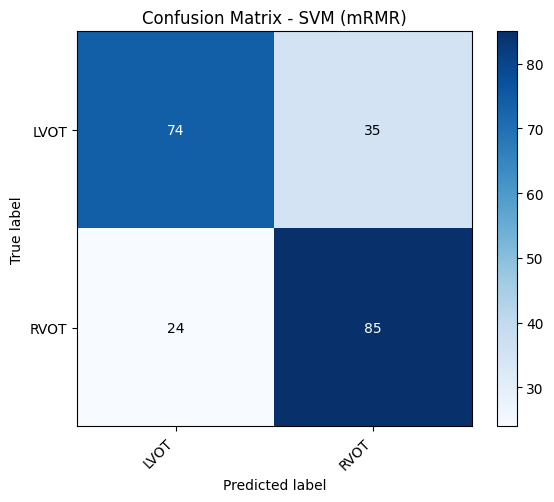

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Function to run SVM and plot results
def run_svm_and_plot(X, y, title_suffix=""):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train
    clf = SVC(kernel="rbf", C=1, gamma="scale")
    clf.fit(X_train_scaled, y_train)

    # Predict
    y_pred = clf.predict(X_test_scaled)

    # Report
    print(f"SVM Classification Report ({title_suffix}):")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(2),
        yticks=np.arange(2),
        xticklabels=["LVOT", "RVOT"],
        yticklabels=["LVOT", "RVOT"],
        xlabel="Predicted label",
        ylabel="True label",
        title=f"Confusion Matrix - SVM ({title_suffix})",
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

# Run SVM for ANOVA and mRMR feature sets
run_svm_and_plot(X_anova_task2, y_encoded_task2, title_suffix="ANOVA")
run_svm_and_plot(X_mrmr_task2, y_encoded_task2, title_suffix="mRMR")
